In [1]:
# Global configuration: all variables and toggles live here
# Centralize config so the rest of the notebook can rely on these variables.
import os, pathlib
from distutils.util import strtobool
from datetime import datetime, timedelta

# --- Secrets & external services ---
# Read from environment if available; do not hardcode secrets here
POLYGON_API_KEY = os.getenv("POLYGON_API_KEY", "")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")
LLM_MODEL = os.getenv("LLM_MODEL", "gpt-5")  # Used by optional LLM analysis blocks

# --- Feature toggles ---
# Accepted truthy env values: '1', 'true', 'yes', 'on' (case-insensitive)
RUN_OPTUNA = bool(strtobool(os.getenv("RUN_OPTUNA", "0")))  # enable hyperparameter search
RUN_LLM    = bool(strtobool(os.getenv("RUN_LLM", "0"))) or bool(OPENAI_API_KEY)  # enable LLM features if key present
DEBUG = False                   # verbose logs
CACHE = True                    # cache monthly parquet
PLOT_SIDE_SPLIT = True          # plot long-only vs short-only equity curves
ACTIVE_SIDE = 'auto'            # 'long' | 'short' | 'auto'
STOP_MODE_DEFAULT = 'tp_sl'     # 'tp_sl' or 'time_only'

# --- Paths ---
BASE_DIR = r"C:\\Users\\ney12\\OneDrive\\Desktop\\data\\orb"
ART_DIR  = os.path.join(BASE_DIR, "artifacts")
PARQ_DIR = os.path.join(BASE_DIR, "parquet")
for p in [BASE_DIR, ART_DIR, PARQ_DIR]:
    pathlib.Path(p).mkdir(parents=True, exist_ok=True)

# --- Data universe & fetch controls ---
TICKERS = ["SPY","QQQ","IWM","TQQQ"]
YEARS_BACK = 10
END = datetime.utcnow().date()
START = (END - timedelta(days=365 * YEARS_BACK))
RATE_SLEEP = 0.25                # seconds between requests
REFRESH_RECENT_MONTHS = 0        # force re-download of last N months

# --- Strategy / execution parameters ---
OPEN_RANGE_MIN = 5               # OR window length in minutes
TAKE_PROFIT_X  = 10              # TP multiple of OR range (if using stops)
FEES_PER_SHARE = 0.0005          # commission per share
SLIPPAGE_BPS   = 2.0             # additional slippage in basis points
SPREAD_BPS     = 2.0             # bid-ask spread in basis points

# --- Optimization spaces ---
OPTUNA_OR_CHOICES = [1, 5, 10, 15, 30]
OPTUNA_TP_CHOICES = [1, 2, 3, 4, 'none']  # 'none' => time-only exit

# --- Target controls (tuning/plots scope) ---
TARGET_TICKER = 'TQQQ'
TARGET_START = None              # e.g., '2020-01-01' or None
TARGET_END = None                # e.g., '2022-12-31' or None

# Propagate to environment for downstream libraries that read from os.environ
if POLYGON_API_KEY:
    os.environ["POLYGON_API_KEY"] = POLYGON_API_KEY
if OPENAI_API_KEY:
    os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["LLM_MODEL"] = LLM_MODEL
os.environ["RUN_OPTUNA"] = "1" if RUN_OPTUNA else "0"
os.environ["RUN_LLM"] = "1" if RUN_LLM else "0"

print(
    "Config → ",
    f"POLYGON_API_KEY={'set' if POLYGON_API_KEY else 'missing'}, ",
    f"OPENAI_API_KEY={'set' if OPENAI_API_KEY else 'missing'}, ",
    f"LLM_MODEL={LLM_MODEL}, RUN_OPTUNA={RUN_OPTUNA}, RUN_LLM={RUN_LLM}, ",
    f"TICKERS={len(TICKERS)} symbols, START={START}, END={END}, DEBUG={DEBUG}"
)

Config →  POLYGON_API_KEY=set,  OPENAI_API_KEY=set,  LLM_MODEL=gpt-5, RUN_OPTUNA=False, RUN_LLM=True,  TICKERS=4 symbols, START=2015-08-16, END=2025-08-13, DEBUG=False


In [2]:
# Secret setup — use environment/config from Cell 1 (no hardcoded secrets)
import os

# Back-compat shim: expose API_KEY from POLYGON_API_KEY if present
API_KEY = os.environ.get("POLYGON_API_KEY", "")
if not API_KEY:
    print("POLYGON_API_KEY missing. Set it in Cell 1 or via environment (e.g., $env:POLYGON_API_KEY='YOUR_KEY').")
else:
    print("POLYGON_API_KEY is set (from Cell 1/env).")

# Simple accessor used elsewhere
def get_api_key() -> str:
    return os.environ.get("POLYGON_API_KEY", "")

_ = len(API_KEY)  # no-op to avoid accidental printing

POLYGON_API_KEY is set (from Cell 1/env).



# ORB Phased Research Pipeline — with Inline Plots

Same phases as before, but with **inline plots** so you don't need to open CSVs.

**Phases**
1. **FAST R&D (ON)** — vectorbt backtest + realistic execution + **plots**
2. **CONFIRMATION (OFF)** — zipline-reloaded mirror *(commented)*
3. **ROBUSTNESS (OFF)** — mlfinlab PurgedKFold + Walk-Forward *(commented)*


In [3]:
# Optional installs (run once if needed)
# !pip install --quiet polars pytz requests exchange_calendars vectorbt pyfolio-reloaded
# (PHASE 2) zipline-reloaded:
# !pip install --quiet zipline-reloaded==3.* alembic==1.13.*
# (PHASE 3) robustness:
# !pip install --quiet mlfinlab optuna

import os, pathlib, warnings, math, json, time, re  # core libs and utils
import numpy as np
import pandas as pd
import polars as pl
import requests
from datetime import datetime, timedelta
import exchange_calendars as xcals  # not strictly required

# Sanity: ensure required secrets/paths exist (all config comes from Cell 1)
api_key = os.environ.get("POLYGON_API_KEY") or os.environ.get("MY_API_KEY") or globals().get("API_KEY")
assert api_key, "Set POLYGON_API_KEY. PowerShell: $env:POLYGON_API_KEY='YOUR_KEY' (or run the first cell)"
print("Polygon key OK.")

Polygon key OK.


# Optuna + LLM configuration

This section installs any missing packages and sets feature flags for experiments.

- RUN_OPTUNA=True to enable hyperparameter search.
- RUN_LLM is preserved if set earlier; otherwise defaults to False.

Run the next cell before executing any tuning code guarded by `if RUN_OPTUNA:`.


In [4]:
# Optuna + LLM setup (idempotent)
# Ensures optuna is installed only if RUN_OPTUNA is enabled.
import sys, subprocess, os

def ensure(pkg: str, import_name: str | None = None, extras: str | None = None) -> None:
    name = pkg if not extras else f"{pkg}[{extras}]"
    try:
        __import__((import_name or pkg).split("[")[0])
        return
    except Exception:
        print(f"Installing {name}...", flush=True)
        subprocess.check_call([sys.executable, "-m", "pip", "install", name])

# Only ensure optuna if requested via Cell 1
if RUN_OPTUNA:
    ensure("optuna")

# Preserve RUN_LLM as set in Cell 1; install optional libs only if enabled
if RUN_LLM and os.getenv("OPENAI_API_KEY"):
    try:
        __import__("openai")
    except Exception:
        # Optional: uncomment to auto-install
        # ensure("openai")
        print("Note: openai package not found. Install it to use LLM features.")

print(f"RUN_OPTUNA={RUN_OPTUNA}, RUN_LLM={RUN_LLM}")

RUN_OPTUNA=False, RUN_LLM=True


## Data Loader — Polygon → Polars → RTH filter

In [5]:
import re  # regex for parsing cached filenames

def _month_iter(start_date: datetime, end_date: datetime):  # iterate month boundaries between dates
    cur = pd.Timestamp(start_date).to_period('M')
    endp = pd.Timestamp(end_date).to_period('M')
    while cur <= endp:
        y, m = cur.year, cur.month
        first = pd.Timestamp(year=y, month=m, day=1)
        last  = (first + pd.offsets.MonthEnd(0)).to_pydatetime()
        yield first.date(), last.date()
        cur = (first + pd.offsets.MonthBegin(1)).to_period('M')

def _parq_path(ticker: str, dt: datetime):
    y = dt.year; m = dt.month
    return os.path.join(PARQ_DIR, f"{ticker}_{y:04d}-{m:02d}.parquet")

def _normalize_schema(df: pl.DataFrame) -> pl.DataFrame:
    if df.is_empty():
        return df
    casts = []
    for col, dtype in ("DateUTC", pl.Datetime("ms")), ("Open", pl.Float64), ("High", pl.Float64), ("Low", pl.Float64), ("Close", pl.Float64), ("Volume", pl.Float64):
        if col in df.columns:
            casts.append(pl.col(col).cast(dtype))
    if casts:
        df = df.with_columns(casts)
    return df

def _list_cached_months(ticker: str) -> set[tuple[int,int]]:
    patt = re.compile(rf"^{re.escape(ticker)}_(\d{{4}})-(\d{{2}})\.parquet$")
    cached = set()
    try:
        for name in os.listdir(PARQ_DIR):
            m = patt.match(name)
            if m:
                y, mm = int(m.group(1)), int(m.group(2))
                cached.add((y, mm))
    except FileNotFoundError:
        pass
    return cached

def polygon_agg_minute_pl(ticker: str, start_date: str, end_date: str, adjusted: bool=True, limit: int=50000) -> pl.DataFrame:
    # Resolve API key from env or inline fallback
    _key = os.environ.get("POLYGON_API_KEY") or os.environ.get("MY_API_KEY") or globals().get("API_KEY")
    if not _key:
        raise RuntimeError("Polygon API key not set. Run Cell 1 or set POLYGON_API_KEY.")

    def _fetch_range(s_date: str, e_date: str) -> list:
        url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/minute/{s_date}/{e_date}"
        params = {"adjusted": str(adjusted).lower(), "sort": "asc", "limit": limit, "apiKey": _key}
        out = []; next_url = None; page = 1
        while True:
            if DEBUG:
                print(f"[Polygon] GET page {page}:", (next_url or url))
            r = requests.get(next_url or url, params=None if next_url else params, timeout=30)
            if r.status_code == 429:
                if DEBUG:
                    print("[Polygon] 429 rate-limited, sleeping 1.0s")
                time.sleep(1.0)
                continue
            try:
                r.raise_for_status()
            except Exception as e:
                print(f"[Polygon] HTTP error for {ticker}:", e)
                try:
                    print("Body:", r.text[:500])
                except Exception:
                    pass
                break
            try:
                data = r.json()
            except Exception as e:
                print("[Polygon] JSON parse error:", e)
                break
            if DEBUG:
                print("[Polygon] status:", data.get("status"), "resultsCount:", data.get("resultsCount"))
                if data.get("error") or data.get("message"):
                    print("[Polygon] message:", data.get("error") or data.get("message"))
            out.extend(data.get("results", []))
            next_url = data.get("next_url")
            if not next_url:
                break
            page += 1
            time.sleep(RATE_SLEEP)
        return out

    # Determine which months to fetch vs. read from cache
    cached = _list_cached_months(ticker)
    months = list(_month_iter(pd.to_datetime(start_date), pd.to_datetime(end_date)))
    refresh_cut = len(months) - REFRESH_RECENT_MONTHS if REFRESH_RECENT_MONTHS > 0 else len(months)

    out_frames: list[pl.DataFrame] = []
    for idx, (m_start, m_end) in enumerate(months):
        y, mm = pd.Timestamp(m_start).year, pd.Timestamp(m_start).month
        cache_path = _parq_path(ticker, pd.Timestamp(m_start))
        use_cache = CACHE and ((y, mm) in cached) and (idx < refresh_cut)

        pl_df = None
        if use_cache:
            try:
                if DEBUG:
                    print(f"[Cache] Hit {cache_path}")
                pl_df = pl.read_parquet(cache_path)
                pl_df = _normalize_schema(pl_df)
            except Exception as e:
                print(f"[Cache] Read failed for {cache_path}: {e}")
                pl_df = None
        if pl_df is None:
            results = _fetch_range(str(m_start), str(m_end))
            if not results:
                if DEBUG:
                    print(f"[Polygon] No results for {ticker} in {m_start}..{m_end}")
                continue
            pl_df = pl.from_dicts(results).with_columns([
                pl.col("t").cast(pl.Datetime("ms")).alias("DateUTC"),
                pl.col("o").cast(pl.Float64).alias("Open"),
                pl.col("h").cast(pl.Float64).alias("High"),
                pl.col("l").cast(pl.Float64).alias("Low"),
                pl.col("c").cast(pl.Float64).alias("Close"),
                pl.col("v").cast(pl.Float64).alias("Volume"),
            ]).select(["DateUTC","Open","High","Low","Close","Volume"]).sort("DateUTC")
            pl_df = _normalize_schema(pl_df)
            if CACHE:
                try:
                    pl_df.write_parquet(cache_path)
                    if DEBUG:
                        print(f"[Cache] Wrote {cache_path}")
                except Exception as e:
                    print(f"[Cache] Write failed for {cache_path}: {e}")
        out_frames.append(pl_df)
        time.sleep(RATE_SLEEP)

    if not out_frames:
        print(f"Warning: No Polygon results for {ticker} between {start_date} and {end_date}.")
        return pl.DataFrame({"Date":[],"Open":[],"High":[],"Low":[],"Close":[],"Volume":[]}).with_columns(pl.col("Date").cast(pl.Datetime))

    df = pl.concat(out_frames, how="vertical_relaxed").unique(maintain_order=True)
    # Convert to NY time RTH window
    df = df.with_columns(pl.col("DateUTC").dt.replace_time_zone("UTC").dt.convert_time_zone("America/New_York").alias("Date"))
    df = df.filter((pl.col("Date").dt.time() >= pl.time(9,30)) & (pl.col("Date").dt.time() <= pl.time(16,0)))
    df = df.with_columns(pl.col("Date").dt.replace_time_zone(None)).drop("DateUTC")
    return df

panels = {}
for tk in TICKERS:
    pl_df = polygon_agg_minute_pl(tk, START.isoformat(), END.isoformat())
    pdf = pl_df.select(["Date","Open","High","Low","Close","Volume"]).to_pandas().set_index("Date").sort_index()
    panels[tk] = pdf
    print(tk, "bars:", len(pdf))

# Drop empty tickers to avoid hard-stop when data is unavailable
_empty = [tk for tk, pdf in panels.items() if pdf.empty]
if _empty:
    print("Warning: dropping tickers with no data:", ", ".join(_empty))
    for tk in _empty:
        del panels[tk]

SPY bars: 978350
QQQ bars: 978362
IWM bars: 978350
TQQQ bars: 973025


In [6]:
# Panels summary / debug  # quick glance at fetched panels
if DEBUG:  # only when verbose mode
    if not panels:  # no tickers
        print("[Panels] No tickers available after fetch.")  # notify
    else:  # some panels present
        for tk, pdf in panels.items():  # each ticker
            if pdf.empty:  # empty panel
                print(f"[Panels] {tk}: empty")  # report
                continue  # skip further logging
            print(f"[Panels] {tk}: rows={len(pdf)}, range=({pdf.index.min()} -> {pdf.index.max()})")  # size and range
            print(pdf.head(3))  # first few rows

In [7]:
# Diagnostic: check Polygon API response for TQQQ (small sample)  # lightweight probe
import pprint as _pp  # pretty print

_test_tk = "TQQQ"  # test symbol
_key = os.environ.get("POLYGON_API_KEY") or os.environ.get("MY_API_KEY") or globals().get("API_KEY")  # resolve key
_url = f"https://api.polygon.io/v2/aggs/ticker/{_test_tk}/range/1/minute/{START.isoformat()}/{END.isoformat()}"  # endpoint
_params = {"adjusted": "true", "sort": "asc", "limit": 5, "apiKey": _key}  # params
try:  # wrap in try to avoid hard fail during diagnostics
    _r = requests.get(_url, params=_params, timeout=30)  # HTTP GET
    print("HTTP:", _r.status_code)  # status code
    _data = _r.json()  # parse JSON
    print("status:", _data.get("status"), "resultsCount:", _data.get("resultsCount"))  # high level
    if _data.get("error") or _data.get("message"):  # error message if any
        print("message:", _data.get("error") or _data.get("message"))  # print message
    if _data.get("results"):  # show a few timestamps
        print("sample timestamps (ms):", [row.get("t") for row in _data["results"][:3]])  # sample
except Exception as e:  # on network/parse error
    print("diag error:", e)  # network/parse error

HTTP: 200
status: DELAYED resultsCount: 5
sample timestamps (ms): [1439801580000, 1439812080000, 1439813220000]


# PHASE 1 — FAST R&D (ACTIVE)

In [8]:
import vectorbt as vbt  # vectorbt backtesting engine
import matplotlib.pyplot as plt  # plotting
import pyfolio as pf  # risk metrics (imported; optional use)


def build_orb_signals(pdf: pd.DataFrame, or_minutes: int):  # compute OR and entry signals
    pdf = pdf.copy()  # avoid mutating original
    dates = pdf.index.date  # trading day per row
    times = pdf.index.time  # time of day per row
    cut = (pd.Timestamp("09:30") + pd.Timedelta(minutes=or_minutes)).time()  # OR cutoff time

    # Opening range  # build OR per day
    pdf["day_open"] = pdf.groupby(dates)["Open"].transform("first")  # first open per day
    # Use times < cut so the OR ends just before the cutoff minute (avoids off-by-one inflation)
    in_or = (times >= pd.Timestamp("09:30").time()) & (times < cut)  # mask inside OR window (half-open)
    pdf["or_high"] = pdf["High"].where(in_or).groupby(dates).transform("max")  # OR high
    pdf["or_low"]  = pdf["Low"].where(in_or).groupby(dates).transform("min")  # OR low

    # First breakout after OR, one trade per day  # choose first side that breaks
    long_entries = pd.Series(False, index=pdf.index)  # init long entries
    short_entries = pd.Series(False, index=pdf.index)  # init short entries

    for day, sub in pdf.groupby(pdf.index.date):  # per day
        sub_after_mask = sub.index.time > cut  # after OR cutoff
        if not sub_after_mask.any():  # no data after cutoff
            continue  # skip this day
        # First timestamps that break the OR
        l_idx = sub.index[sub_after_mask & (sub["High"] > sub["or_high"])]  # first long break
        s_idx = sub.index[sub_after_mask & (sub["Low"] < sub["or_low"])]   # first short break
        first_l = l_idx[0] if len(l_idx) > 0 else None  # earliest long break time or None
        first_s = s_idx[0] if len(s_idx) > 0 else None  # earliest short break time or None
        if first_l is None and first_s is None:  # no break
            continue  # skip day if no breakout
        # Pick earliest break and schedule entry on the next bar to avoid same-bar lookahead
        if first_s is None or (first_l is not None and first_l <= first_s):  # choose long if no short or long first
            # Long chosen
            pos = sub.index.get_loc(first_l)  # position index of the breakout bar
            if pos + 1 < len(sub.index):  # ensure next bar exists
                next_ts = sub.index[pos + 1]  # timestamp of the next bar
                long_entries[next_ts] = True  # mark long entry at next bar
        else:  # short chosen branch
            # Short chosen
            pos = sub.index.get_loc(first_s)  # position index of the breakout bar
            if pos + 1 < len(sub.index):  # ensure next bar exists
                next_ts = sub.index[pos + 1]  # timestamp of the next bar
                short_entries[next_ts] = True  # mark short entry at next bar

    exits = (pdf.index.time == pd.Timestamp("15:59").time())  # exit near close
    return pdf, long_entries, short_entries, exits  # return enriched df and signals

# Utility to slice by optional target period
_def_na = object()
def _slice_period(pdf: pd.DataFrame, start: str | None, end: str | None) -> pd.DataFrame:  # helper to subset period
    out = pdf
    if start:  # if start provided
        out = out[out.index >= pd.to_datetime(start)]  # filter by start
    if end:  # if end provided
        out = out[out.index <= pd.to_datetime(end)]  # filter by end
    return out

def simulate_vectorbt(pdf: pd.DataFrame, long_entries: pd.Series, short_entries: pd.Series, exits: pd.Series,
                      tp_mult: float | None, spread_bps: float, slip_bps: float, fees_per_share: float,
                      side: str = 'both', stop_mode: str = 'tp_sl'):  # simulate with optional time-only exit and side
    mid = pdf["Close"]  # mid-price proxy
    spread = spread_bps / 1e4  # spread fraction
    slip = slip_bps / 1e4  # slippage fraction
    ask = mid * (1 + spread/2 + slip)  # buy price
    bid = mid * (1 - spread/2 - slip)  # sell/short price

    # OR range and stop/target levels (absolute levels)
    rng = (pdf["or_high"] - pdf["or_low"]).fillna(0.0)  # OR width
    tp_long_level  = (pdf["or_high"] + (0 if tp_mult is None else tp_mult) * rng)  # absolute long TP level
    sl_long_level  = (pdf["or_low"])                  # absolute long SL level
    tp_short_level = (pdf["or_low"] - (0 if tp_mult is None else tp_mult) * rng)  # absolute short TP level
    sl_short_level = (pdf["or_high"])                 # absolute short SL level

    # Convert absolute levels into fractional distances expected by vectorbt
    if stop_mode == 'tp_sl' and tp_mult is not None:  # use TP/SL
        tp_long_frac = ((tp_long_level - ask) / ask).clip(lower=0).fillna(0.0)  # fractional distance to long TP
        sl_long_frac = ((ask - sl_long_level) / ask).clip(lower=0).fillna(0.0)  # fractional distance to long SL
        tp_short_frac = ((bid - tp_short_level) / bid).clip(lower=0).fillna(0.0)  # fractional distance to short TP
        sl_short_frac = ((sl_short_level - bid) / bid).clip(lower=0).fillna(0.0)  # fractional distance to short SL
    else:  # time-only exit: disable TP/SL
        tp_long_frac = None  # no TP
        sl_long_frac = None  # no SL
        tp_short_frac = None  # no TP
        sl_short_frac = None  # no SL

    # Long-only portfolio on ask
    pf_long = vbt.Portfolio.from_signals(
        close=ask, entries=long_entries, exits=exits,  # prices and long signals
        tp_stop=tp_long_frac, sl_stop=sl_long_frac,  # may be None
        freq="min", fees=fees_per_share, init_cash=25_000, slippage=0.0, accumulate=False  # execution settings
    )  # build long portfolio

    # Short-only portfolio on bid
    false_series = pd.Series(False, index=bid.index)  # no long entries here
    pf_short = vbt.Portfolio.from_signals(
        close=bid,  # use bid for shorts
        entries=false_series, exits=exits,  # long path unused
        short_entries=short_entries, short_exits=exits,  # short path signals
        tp_stop=tp_short_frac, sl_stop=sl_short_frac,  # may be None
        freq="min", fees=fees_per_share, init_cash=25_000, slippage=0.0, accumulate=False  # execution settings
    )  # build short portfolio

    # Equity curves
    eq_long = pf_long.value().ffill().fillna(25_000.0)  # long equity curve
    eq_short = pf_short.value().ffill().fillna(25_000.0)  # short equity curve

    if side == 'long':  # return long only
        return eq_long
    if side == 'short':  # return short only
        return eq_short

    # Default: combine by active side (legacy behavior)
    positions_long = getattr(pf_long, "positions", None)  # position tracker
    if positions_long is not None and hasattr(positions_long, "squeeze"):  # handle vectorbt type
        positions_long = positions_long.squeeze()  # to 1D
        positions_long = pd.Series(positions_long, index=eq_long.index)  # align index
    else:  # fallback when vectorbt Position accessor missing
        positions_long = long_entries.reindex(eq_long.index).fillna(False)  # fallback to entries

    eq = eq_long.where(positions_long != 0, eq_short)  # select curve by active side
    return eq  # final equity series

def _choose_side(eq_long: pd.Series, eq_short: pd.Series) -> str:  # pick stronger side by total return
    ret_l = (eq_long.iloc[-1] / eq_long.iloc[0] - 1) if len(eq_long) else -np.inf  # long return
    ret_s = (eq_short.iloc[-1] / eq_short.iloc[0] - 1) if len(eq_short) else -np.inf  # short return
    return 'long' if ret_l >= ret_s else 'short'  # choose higher return

def evaluate_equity(eq: pd.Series):  # compute performance metrics
    eq = eq.asfreq("min").ffill()  # minute frequency
    r_min = eq.pct_change().dropna()  # minute returns
    r_day = r_min.resample("1D").apply(lambda s: (1+s).prod()-1).dropna()  # daily returns
    ret = (eq.iloc[-1] / eq.iloc[0] - 1) * 100  # total return %
    sharpe = (r_day.mean() / r_day.std() * np.sqrt(252)) if r_day.std() > 0 else np.nan  # daily sharpe
    dd = (eq / eq.cummax() - 1).min() * 100  # max drawdown %
    return {"Return [%]": ret, "Sharpe": sharpe, "MaxDD [%]": dd}, r_day  # metrics and daily series

daily_returns = {}  # ticker -> daily return series
equity_curves = {}  # ticker -> equity curve
side_curves = {}  # ticker -> {long, short}
for tk, pdf in panels.items():  # iterate panels
    # Optionally slice to target period for display consistency
    _pdf = _slice_period(pdf, TARGET_START, TARGET_END)  # period slice
    pdf2, e_long, e_short, x = build_orb_signals(_pdf, OPEN_RANGE_MIN)  # signals
    # Build both sides and combined
    eq_l = simulate_vectorbt(pdf2, e_long, e_short, x, TAKE_PROFIT_X if STOP_MODE_DEFAULT=='tp_sl' else None,
                             SPREAD_BPS, SLIPPAGE_BPS, FEES_PER_SHARE, side='long', stop_mode=STOP_MODE_DEFAULT)  # long-only
    eq_s = simulate_vectorbt(pdf2, e_long, e_short, x, TAKE_PROFIT_X if STOP_MODE_DEFAULT=='tp_sl' else None,
                             SPREAD_BPS, SLIPPAGE_BPS, FEES_PER_SHARE, side='short', stop_mode=STOP_MODE_DEFAULT)  # short-only
    side_curves[tk] = {"long": eq_l, "short": eq_s}  # store

    # Choose active side if requested
    _side = ACTIVE_SIDE
    if _side == 'auto':  # let data decide
        _side = _choose_side(eq_l, eq_s)  # pick stronger
    if _side == 'long':
        eq = eq_l
    elif _side == 'short':
        eq = eq_s
    else:
        # combined legacy behavior
        eq = simulate_vectorbt(pdf2, e_long, e_short, x, TAKE_PROFIT_X if STOP_MODE_DEFAULT=='tp_sl' else None,
                               SPREAD_BPS, SLIPPAGE_BPS, FEES_PER_SHARE, side='both', stop_mode=STOP_MODE_DEFAULT)

    equity_curves[tk] = eq  # store equity
    _, r_day = evaluate_equity(eq)  # compute daily returns
    daily_returns[tk] = r_day  # store daily returns

# Summary table (programmatic) and human-friendly view
rows = []  # rows accumulator
for tk, eq in equity_curves.items():  # loop results
    m, _ = evaluate_equity(eq)  # metrics
    rows.append({"Ticker": tk, **m})  # build row
res_phase1 = pd.DataFrame(rows).sort_values("Return [%]", ascending=False)  # table sorted by return
# Human-friendly labels for display
_res_colmap = {"Return [%]": "Total Return (%)", "Sharpe": "Sharpe Ratio", "MaxDD [%]": "Max Drawdown (%)"}
res_phase1_h = res_phase1.rename(columns=_res_colmap)  # renamed copy for display
res_phase1_h  # display table with friendly labels

,Ticker,Total Return (%),Sharpe Ratio,Max Drawdown (%)
3,TQQQ,-53.809199,-0.152519,-75.351790
1,QQQ,-61.681503,-0.886568,-65.117741
0,SPY,-64.662302,-1.396281,-66.155225
2,IWM,-70.564745,-1.194424,-71.946873


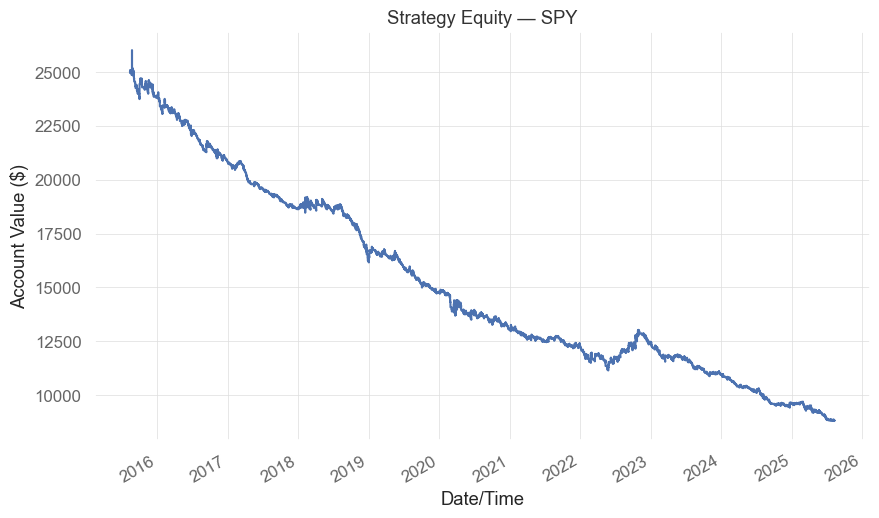

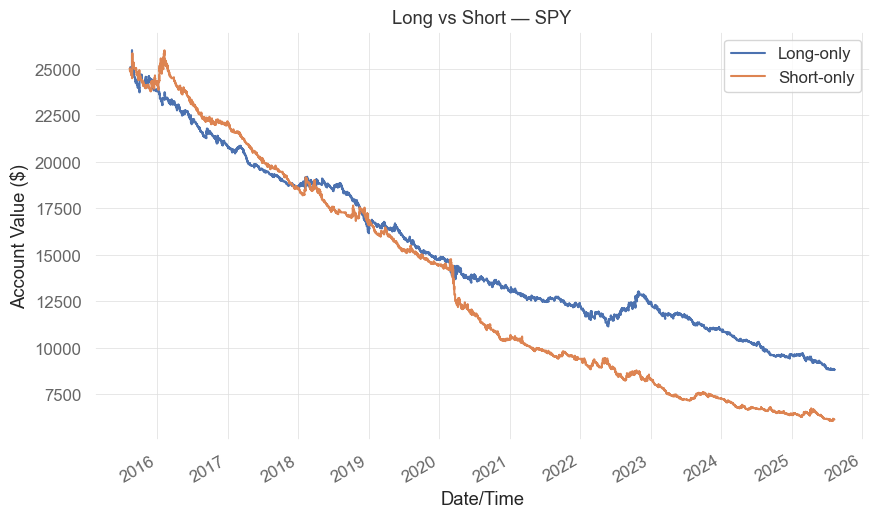

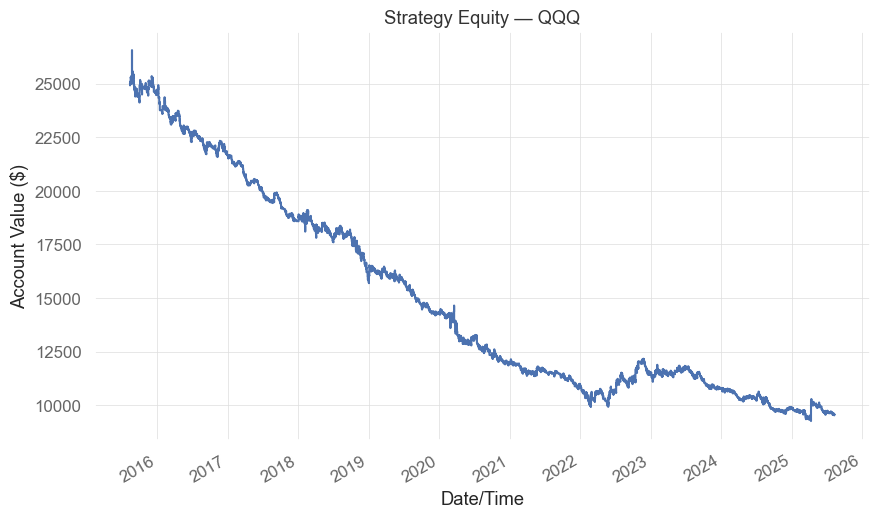

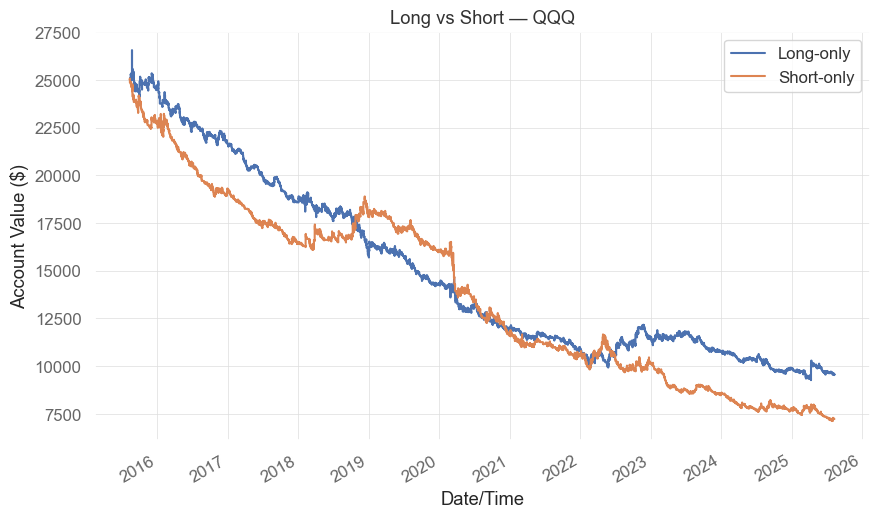

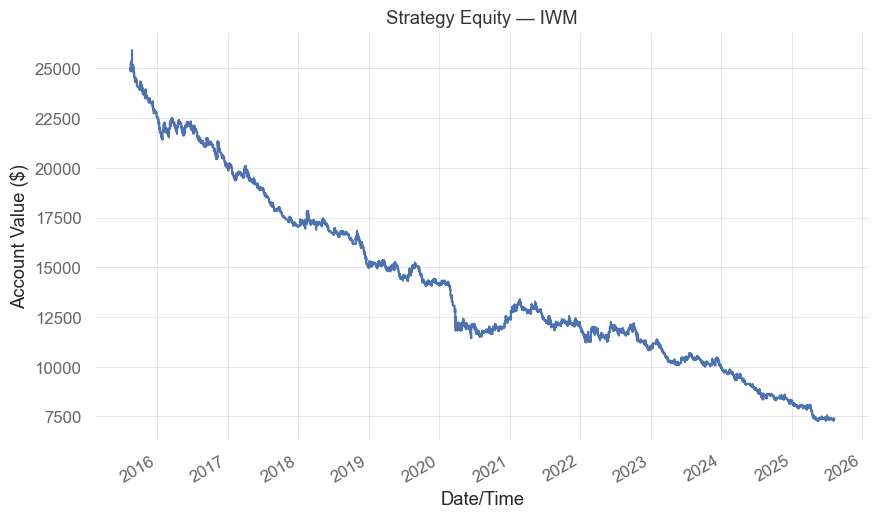

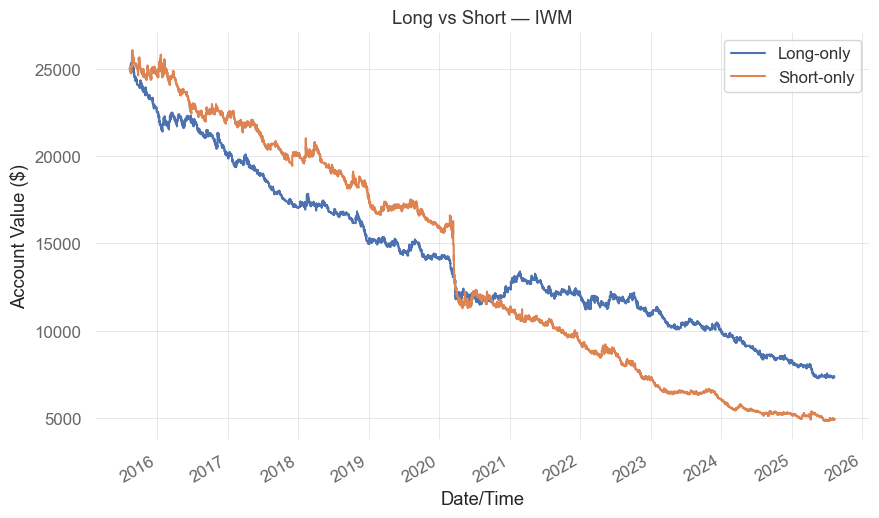

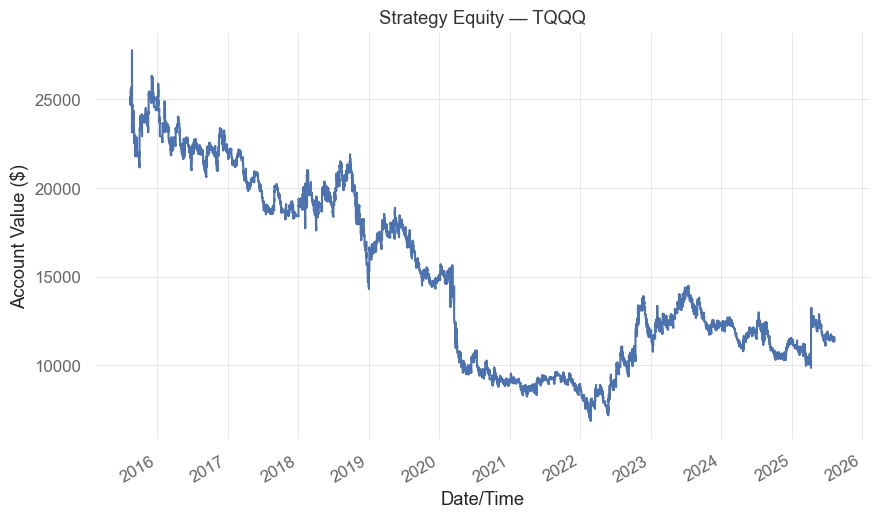

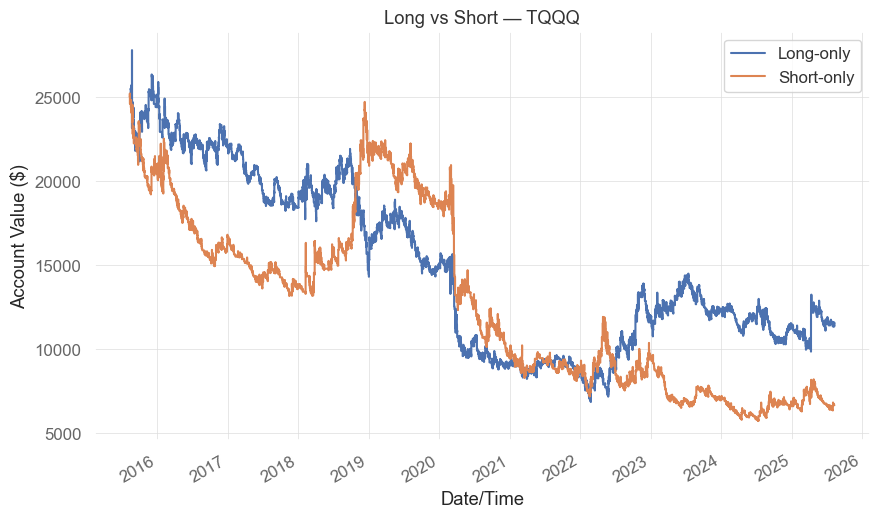

In [9]:
# Equity curves — per ticker
import matplotlib.pyplot as plt  # plotting (already imported; safe)

for tk, eq in equity_curves.items():  # iterate equities
    plt.figure()  # new figure
    eq.plot(title=f"Strategy Equity — {tk}")  # plot series
    plt.xlabel("Date/Time")  # x label
    plt.ylabel("Account Value ($)")  # y label

    if PLOT_SIDE_SPLIT and tk in side_curves:  # optional split view
        plt.figure()  # new figure for side split
        side_curves[tk]["long"].plot(label="Long-only")  # long-only
        side_curves[tk]["short"].plot(label="Short-only")  # short-only
        plt.title(f"Long vs Short — {tk}")  # title
        plt.xlabel("Date/Time")  # x label
        plt.ylabel("Account Value ($)")  # y label
        plt.legend()  # legend

Text(0, 0.5, 'Max Drawdown (%)')

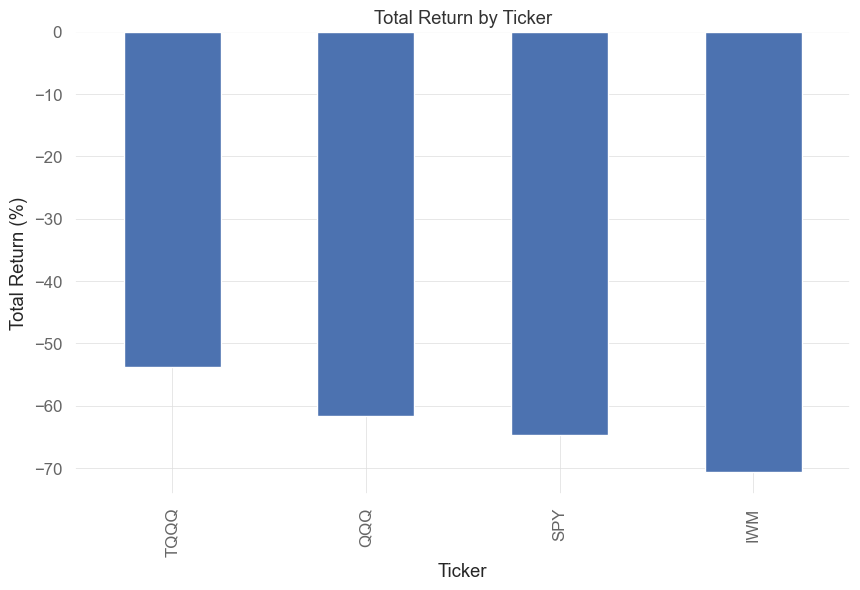

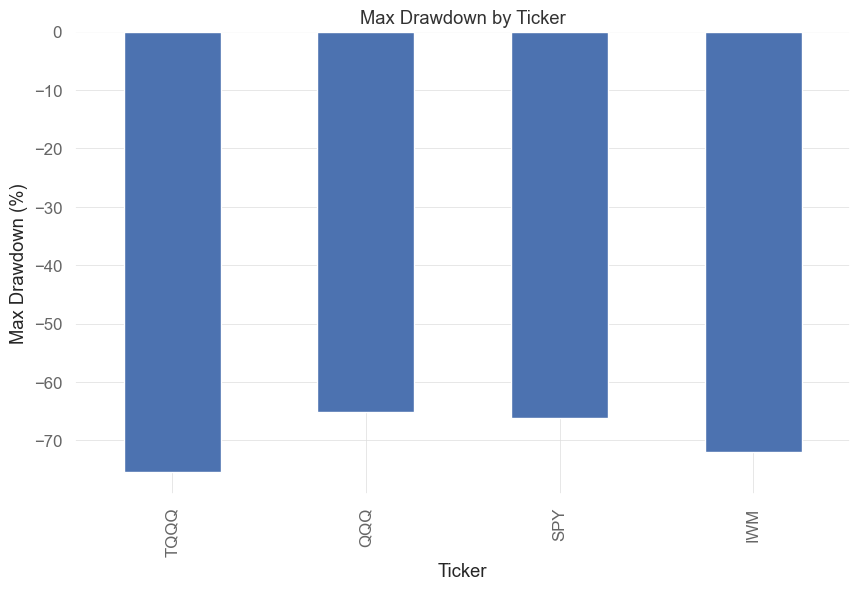

In [10]:
# Bar charts for Total Return and Max Drawdown — quick per-ticker comparison
plt.figure()  # new figure
res_phase1_h.set_index("Ticker")["Total Return (%)"].plot(kind="bar", title="Total Return by Ticker")  # returns
plt.xlabel("Ticker")  # label
plt.ylabel("Total Return (%)")  # label

plt.figure()  # new figure
res_phase1_h.set_index("Ticker")["Max Drawdown (%)"].plot(kind="bar", title="Max Drawdown by Ticker")  # drawdowns
plt.xlabel("Ticker")  # label
plt.ylabel("Max Drawdown (%)")  # label

In [ ]:
# Cross-symbol best search (small OR×TP grid) — summary and winner plot
print("Running small grid search per symbol (fixed costs; auto-select side).")

from math import isfinite

def _grid_best_for_ticker(tk: str):  # evaluate small grid and return best config, equity, and metrics
    pdf_full = panels[tk]
    pdf = _slice_period(pdf_full, TARGET_START, TARGET_END)
    best = None
    best_eq = None
    best_metrics = None
    for or_min in OPTUNA_OR_CHOICES:
        pdf2, e_long, e_short, x = build_orb_signals(pdf, or_min)
        for tp_choice in OPTUNA_TP_CHOICES:
            stop_mode = 'tp_sl' if tp_choice != 'none' else 'time_only'
            tp_mult = None if tp_choice == 'none' else float(tp_choice)
            # simulate both sides
            eq_l = simulate_vectorbt(pdf2, e_long, e_short, x, tp_mult, SPREAD_BPS, SLIPPAGE_BPS, FEES_PER_SHARE, side='long', stop_mode=stop_mode)
            eq_s = simulate_vectorbt(pdf2, e_long, e_short, x, tp_mult, SPREAD_BPS, SLIPPAGE_BPS, FEES_PER_SHARE, side='short', stop_mode=stop_mode)
            side = _choose_side(eq_l, eq_s)
            eq = eq_l if side=='long' else eq_s
            metrics, _ = evaluate_equity(eq)
            # rank by Sharpe, then Return, then smaller drawdown
            sharpe = metrics['Sharpe'] if isfinite(metrics['Sharpe']) else -1e9
            ret = metrics['Return [%]']
            dd = metrics['MaxDD [%]']
            rank_key = (sharpe, ret, -abs(dd))
            if best is None or rank_key > best['rank_key']:
                best = {"Ticker": tk, "or_min": or_min, "tp": tp_choice, "side": side, "rank_key": rank_key}
                best_eq = eq
                best_metrics = metrics
    return best, best_eq, best_metrics

best_rows = []
best_equities = {}
for tk in panels.keys():
    b, eq, m = _grid_best_for_ticker(tk)
    best_rows.append({**{k: v for k, v in b.items() if k != 'rank_key'}, **m})
    best_equities[tk] = eq

best_by_symbol = pd.DataFrame(best_rows).sort_values(['Sharpe','Return [%]'], ascending=[False, False]).reset_index(drop=True)
print("\n==== Best settings per symbol ====")
display(best_by_symbol)

# Overall winner by Sharpe then Return
if not best_by_symbol.empty:
    win = best_by_symbol.iloc[0]
    wt = win['Ticker']
    print("\n==== Overall winner ====")
    print(f"Ticker: {wt} | Side: {win['side']} | OR: {win['or_min']} min | TP: {win['tp']} | Return: {win['Return [%]']:.2f}% | Sharpe: {win['Sharpe']:.2f} | MaxDD: {win['MaxDD [%]']:.2f}%")
    # Plot winner equity and optionally side-split + buy & hold
    eq_w = best_equities[wt]
    plt.figure()
    eq_w.plot(label='Strategy')
    plt.title(f"Winner — {wt} (side={win['side']}, OR={win['or_min']}, TP={win['tp']})")
    plt.xlabel("Time"); plt.ylabel("Equity ($)"); plt.legend()

    # Buy & Hold overlay
    _pdf_full = panels[wt]
    _pdf = _slice_period(_pdf_full, TARGET_START, TARGET_END)
    if not _pdf.empty:
        _close = _pdf['Close'].dropna()
        if not _close.empty:
            _shares = 25_000 / _close.iloc[0]
            _eq_bh = (_shares * _close).reindex(eq_w.index).ffill().dropna()
            plt.figure()
            eq_w.plot(label='Strategy')
            _eq_bh.plot(label='Buy & Hold')
            plt.title(f"Winner vs Buy & Hold — {wt}")
            plt.xlabel("Time"); plt.ylabel("Equity ($)"); plt.legend()

    # Optional side-split using the winner's OR/TP
    if PLOT_SIDE_SPLIT:
        _or = int(win['or_min']); _tp = win['tp']
        _stop_mode = 'tp_sl' if _tp != 'none' else 'time_only'
        _tp_mult = None if _tp == 'none' else float(_tp)
        _pdf2, _eL, _eS, _x = build_orb_signals(_pdf, _or)
        _eqL = simulate_vectorbt(_pdf2, _eL, _eS, _x, _tp_mult, SPREAD_BPS, SLIPPAGE_BPS, FEES_PER_SHARE, side='long', stop_mode=_stop_mode)
        _eqS = simulate_vectorbt(_pdf2, _eL, _eS, _x, _tp_mult, SPREAD_BPS, SLIPPAGE_BPS, FEES_PER_SHARE, side='short', stop_mode=_stop_mode)
        plt.figure(); _eqL.plot(label='Long only'); _eqS.plot(label='Short only'); plt.title(f"Side split — {wt}"); plt.xlabel("Time"); plt.ylabel("Equity ($)"); plt.legend()
else:
    print("No symbols available for cross-symbol search.")

Running small grid search per symbol (fixed costs; auto-select side).


## Stop vs Take-Profit Sharpe heatmap for the best ticker

This section selects the best ticker/strategy found earlier and scans a grid of Stop-Loss and Take-Profit multiples (relative to the opening range) to visualize which combination maximizes Sharpe Ratio.

Best ticker selected for heatmap: TQQQ
No finite Sharpe values across grid. Falling back to Total Return (%) for visualization.
No finite Sharpe values across grid. Falling back to Total Return (%) for visualization.
Saved heatmap to: C:\\Users\\ney12\\OneDrive\\Desktop\\data\\orb\artifacts\TQQQ_heatmap_side-long_or-5.png
Saved data to: C:\\Users\\ney12\\OneDrive\\Desktop\\data\\orb\artifacts\TQQQ_heatmap_side-long_or-5.csv
Saved heatmap to: C:\\Users\\ney12\\OneDrive\\Desktop\\data\\orb\artifacts\TQQQ_heatmap_side-long_or-5.png
Saved data to: C:\\Users\\ney12\\OneDrive\\Desktop\\data\\orb\artifacts\TQQQ_heatmap_side-long_or-5.csv


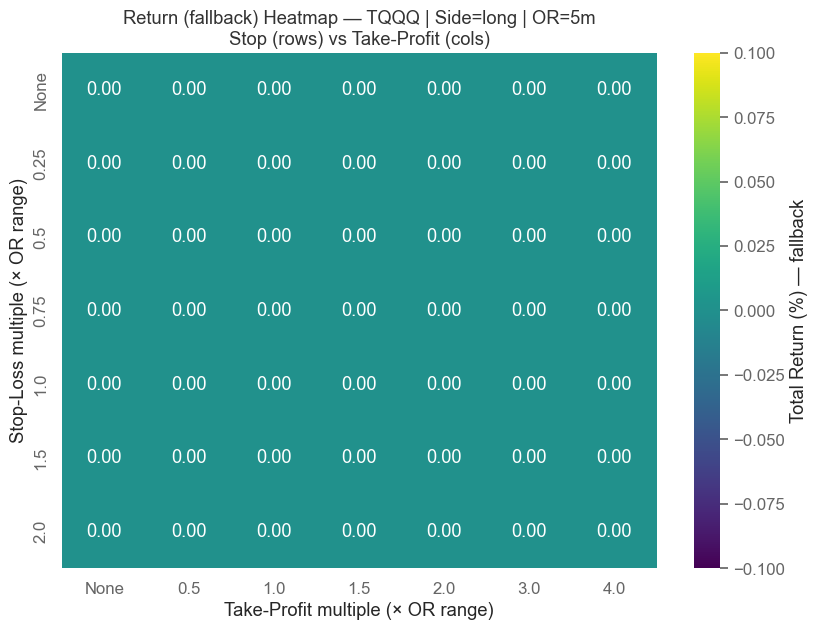

In [ ]:
# Build Stop vs Take-Profit Sharpe heatmap for the best ticker/strategy  # High-level goal of this cell
import numpy as np  # Numerical operations (NaNs, isfinite, arrays)
import pandas as pd  # DataFrame/Series for tabular computations
import matplotlib.pyplot as plt  # Plotting backend
import warnings  # Manage noisy warnings

# Quiet some common non-critical warnings
warnings.filterwarnings('ignore', message='.*tight_layout.*', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')

# Try seaborn; fall back to matplotlib if not installed
try:
    import seaborn as sns  # Optional: nicer heatmaps
    _HAS_SNS = True  # Flag to use seaborn heatmap if available
except Exception:  # If seaborn is missing or import fails
    _HAS_SNS = False  # Fall back to plain matplotlib

# Assumptions: variables from earlier cells
# - best_by_symbol: DataFrame with best settings per ticker
# - panels: dict of per-ticker OHLCV DataFrames
# - simulate_vectorbt(pdf, ...): returns equity Series
# - evaluate_equity(eq): returns metrics; can be dict/Series/tuple
# - ACTIVE_SIDE can be 'auto', 'long', or 'short'; we will respect best['Side'] if available

# Helper to extract metric from evaluate_equity output
def _extract_metric(m, keys):
    try:
        if isinstance(m, dict):
            for key in keys:
                if key in m:
                    return float(m[key])
            for k, v in m.items():
                if isinstance(k, str) and any(k.lower() == kk.lower() for kk in keys):
                    return float(v)
            return np.nan
        if isinstance(m, pd.Series):
            for key in keys:
                if key in m.index:
                    return float(m[key])
            for k, v in m.items():
                if isinstance(k, str) and any(k.lower() == kk.lower() for kk in keys):
                    return float(v)
            return np.nan
        if isinstance(m, (list, tuple)):
            for el in m:
                if isinstance(el, (dict, pd.Series)):
                    v = _extract_metric(el, keys)
                    if pd.notna(v):
                        return float(v)
            return np.nan
        return np.nan
    except Exception:
        return np.nan

# Helper to call simulate_vectorbt with flexible kwarg names
def _simulate_flex(pdf, or_minutes, tp, sl, side, stop_mode):
    or_kw = [
        {'or_minutes': or_minutes},
        {'open_range_min': or_minutes},
        {'or_min': or_minutes},
    ]
    base = {'side': side, 'stop_mode': stop_mode, 'take_profit_x': tp}
    last_err = None
    for ok in or_kw:
        kwargs = {}
        kwargs.update(base)
        kwargs.update(ok)
        try:
            return simulate_vectorbt(pdf, **kwargs)
        except TypeError as e:
            last_err = e
            continue
        except Exception as e:
            last_err = e
            continue
    # final fallback without take_profit_x when None
    if tp is None:
        for ok in or_kw:
            try:
                return simulate_vectorbt(pdf, side=side, stop_mode=stop_mode, **ok)
            except Exception as e:
                last_err = e
                continue
    raise last_err if last_err else RuntimeError('simulate_vectorbt could not be called with available signatures')

# 1) Choose the best ticker/strategy discovered earlier.
best_ticker = None
best_row = {}
if 'best_by_symbol' in globals() and isinstance(best_by_symbol, pd.DataFrame) and not best_by_symbol.empty:
    bb = best_by_symbol.copy()
    rank_cols = [c for c in bb.columns if c.lower().startswith('sharpe')]
    sharpe_col = rank_cols[0] if rank_cols else 'Sharpe'
    ret_cols = [c for c in bb.columns if 'return' in c.lower()]
    ret_col = ret_cols[0] if ret_cols else 'Return [%]'
    bb = bb.sort_values([sharpe_col, ret_col], ascending=[False, False])

    # Determine ticker robustly
    ticker_candidates = []
    try:
        ticker_candidates.append(bb.index[0])
    except Exception:
        pass
    for col in ['Ticker', 'ticker', 'Symbol', 'symbol', 'tk', 'instrument', 'Instrument']:
        if col in bb.columns:
            ticker_candidates.append(bb.iloc[0][col])
    for col in bb.columns:
        ticker_candidates.append(bb.iloc[0][col])

    for cand in ticker_candidates:
        try:
            cs = str(cand)
        except Exception:
            continue
        if cs in panels:
            best_ticker = cs
            break

    if best_ticker is None:
        best_ticker = TARGET_TICKER

    best_row = bb.iloc[0].to_dict()
else:
    best_ticker = TARGET_TICKER
    best_row = {}

print(f"Best ticker selected for heatmap: {best_ticker}")

# 2) Retrieve base data and base parameters
pdf_b = panels[best_ticker]
# Ensure proper sorting/index for stability
if hasattr(pdf_b, 'sort_index'):
    pdf_b = pdf_b.sort_index()

or_candidates = [
    best_row.get('OR minutes'), best_row.get('OR Minutes'), best_row.get('OR'),
    best_row.get('Open Range (min)'), best_row.get('OR_min'), OPEN_RANGE_MIN
]
or_minutes = int([v for v in or_candidates if v is not None][0])

side_candidates = [best_row.get('Side'), best_row.get('Selected Side'), ACTIVE_SIDE]
selected_side = [v for v in side_candidates if v is not None][0]

if selected_side == 'auto':
    if 'side_curves' in globals() and isinstance(side_curves, dict) and best_ticker in side_curves:
        e_l = side_curves[best_ticker].get('long')
        e_s = side_curves[best_ticker].get('short')
        sh_l = _extract_metric(evaluate_equity(e_l)[0], ['Sharpe']) if e_l is not None else -np.inf
        sh_s = _extract_metric(evaluate_equity(e_s)[0], ['Sharpe']) if e_s is not None else -np.inf
        selected_side = 'long' if sh_l >= sh_s else 'short'
    else:
        selected_side = 'long'

# 3) Define scan grids for Stop and Take-Profit multiples
stop_grid = [None, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
tp_grid   = [None, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0]

# 4) Compute Sharpe for each combination, and keep Return for fallback
heat_sh = pd.DataFrame(index=[str(s) for s in stop_grid], columns=[str(t) for t in tp_grid], dtype=float)
heat_ret = pd.DataFrame(index=[str(s) for s in stop_grid], columns=[str(t) for t in tp_grid], dtype=float)
best_metric = -np.inf
best_combo = (None, None)

for s in stop_grid:
    for t in tp_grid:
        stop_mode = 'time_only' if (s is None and t is None) else 'tp_sl'
        try:
            eq = _simulate_flex(
                pdf_b,
                or_minutes=or_minutes,
                tp=t,
                sl=s,
                side=selected_side,
                stop_mode=stop_mode
            )
            # Ensure Series numeric, drop obvious NaNs
            if isinstance(eq, pd.Series):
                eq = pd.to_numeric(eq, errors='coerce')
            met, _ = evaluate_equity(eq)
            sh = _extract_metric(met, ['Sharpe', 'Sharpe Ratio'])
            rt = _extract_metric(met, ['Return [%]', 'Total Return (%)'])
        except Exception:
            sh, rt = np.nan, np.nan
        heat_sh.loc[str(s), str(t)] = sh
        heat_ret.loc[str(s), str(t)] = rt
        if np.isfinite(sh) and sh > best_metric:
            best_metric = sh
            best_combo = (s, t)

finite_any = np.isfinite(heat_sh.values).any()

if not finite_any:
    print("No finite Sharpe values across grid. Falling back to Total Return (%) for visualization.")
    plot_df = heat_ret.copy()
    cbar_label = 'Total Return (%) — fallback'
    title_metric = 'Return (fallback)'
else:
    plot_df = heat_sh.copy()
    cbar_label = 'Sharpe Ratio'
    title_metric = 'Sharpe'

# If still all-NaN (e.g., no trades), fill zeros so the plot isn't empty
if not np.isfinite(plot_df.values).any():
    plot_df = plot_df.fillna(0.0)

# 5) Plot heatmap
plt.figure(figsize=(8.5, 6.5))
if _HAS_SNS:
    sns.heatmap(plot_df.astype(float), annot=True, fmt='.2f', cmap='viridis', cbar_kws={'label': cbar_label})
else:
    data = plot_df.astype(float).values
    im = plt.imshow(data, cmap='viridis', aspect='auto')
    plt.colorbar(im, label=cbar_label)
    plt.xticks(ticks=np.arange(len(tp_grid)), labels=[str(t) for t in tp_grid])
    plt.yticks(ticks=np.arange(len(stop_grid)), labels=[str(s) for s in stop_grid])
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data[i, j]
            if np.isfinite(val):
                plt.text(j, i, f"{val:.2f}", ha='center', va='center', color='white')

plt.title(f"{title_metric} Heatmap — {best_ticker} | Side={selected_side} | OR={or_minutes}m\nStop (rows) vs Take-Profit (cols)")
plt.xlabel('Take-Profit multiple (× OR range)')
plt.ylabel('Stop-Loss multiple (× OR range)')
plt.tight_layout()

# 6) Optional: Save figure and data
try:
    import os
    os.makedirs(ART_DIR, exist_ok=True)
    outp_fig = os.path.join(ART_DIR, f"{best_ticker}_heatmap_side-{selected_side}_or-{or_minutes}.png")
    outp_csv = os.path.join(ART_DIR, f"{best_ticker}_heatmap_side-{selected_side}_or-{or_minutes}.csv")
    plt.savefig(outp_fig, dpi=150)
    plot_df.to_csv(outp_csv)
    print(f"Saved heatmap to: {outp_fig}\nSaved data to: {outp_csv}")
except Exception:
    pass

plt.show()


## OR minutes × TP choice grid (Sharpe and Return)

Visualize how different Optuna search choices for Opening Range minutes and Take-Profit affect performance on the selected ticker. The grid shows Sharpe and Total Return for each (OR, TP) pair with realistic costs.

Saved: C:\\Users\\ney12\\OneDrive\\Desktop\\data\\orb\artifacts\TQQQ_grid_orx_tp_primary.png
Saved: C:\\Users\\ney12\\OneDrive\\Desktop\\data\\orb\artifacts\TQQQ_grid_orx_tp_secondary.png


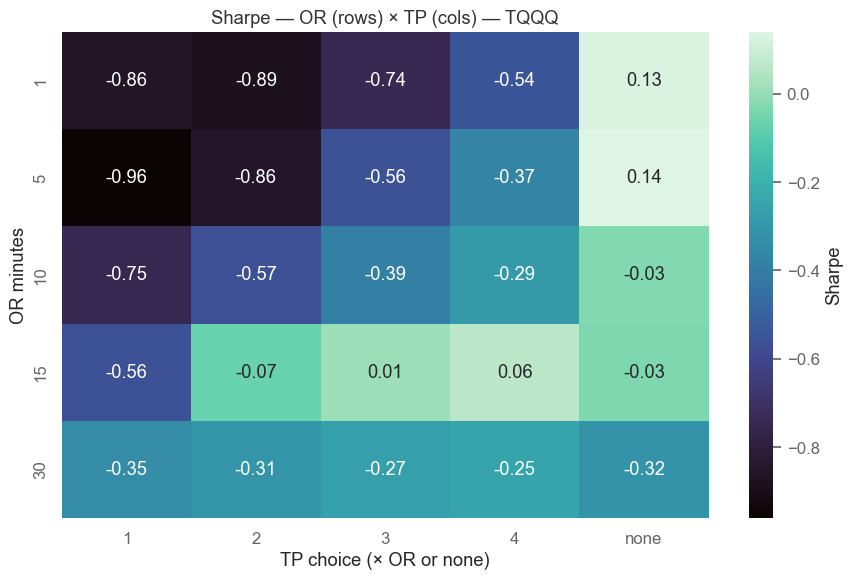

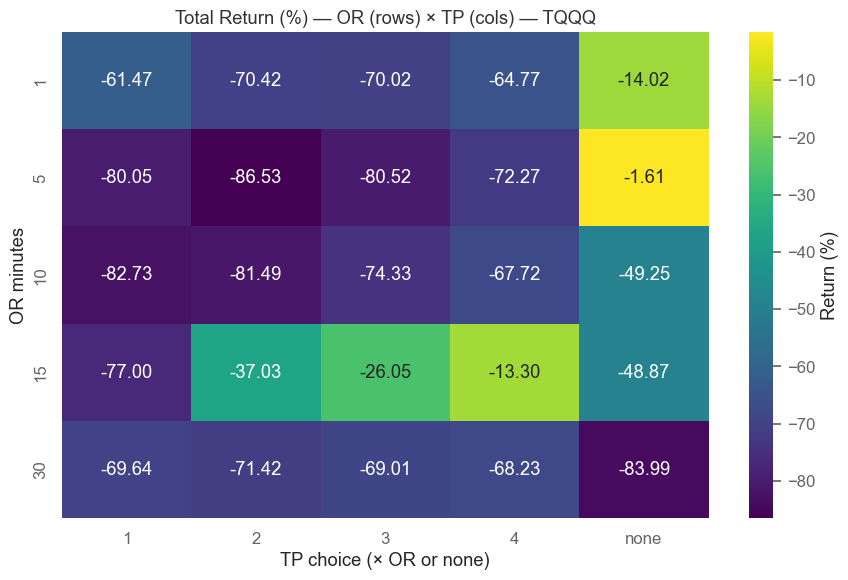

In [ ]:
# Compute OR minutes × TP choice grid (Sharpe and Return) for the selected/best ticker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Determine target ticker and side similar to the heatmap section
_ticker = None
if 'best_ticker' in globals() and isinstance(best_ticker, str):
    _ticker = best_ticker
elif 'TARGET_TICKER' in globals():
    _ticker = TARGET_TICKER
else:
    _ticker = next(iter(panels)) if panels else None

if _ticker is None or _ticker not in panels or panels[_ticker].empty:
    print("Skipping OR×TP grid: no valid ticker/panel available.")
else:
    pdf_full = panels[_ticker]
    pdf = _slice_period(pdf_full, TARGET_START, TARGET_END)

    # Utility: evaluate for given (or_min, tp_choice)
    def _eval(or_min: int, tp_choice):
        _pdf2, _eL, _eS, _x = build_orb_signals(pdf, or_min)
        stop_mode = 'tp_sl' if tp_choice != 'none' else 'time_only'
        tp_mult = None if tp_choice == 'none' else float(tp_choice)
        eq_l = simulate_vectorbt(_pdf2, _eL, _eS, _x, tp_mult, SPREAD_BPS, SLIPPAGE_BPS, FEES_PER_SHARE, side='long', stop_mode=stop_mode)
        eq_s = simulate_vectorbt(_pdf2, _eL, _eS, _x, tp_mult, SPREAD_BPS, SLIPPAGE_BPS, FEES_PER_SHARE, side='short', stop_mode=stop_mode)
        side = _choose_side(eq_l, eq_s) if ACTIVE_SIDE == 'auto' else ACTIVE_SIDE
        eq = eq_l if side == 'long' else eq_s
        metrics, _ = evaluate_equity(eq)
        return side, metrics

    # Prepare grids
    or_vals = [int(v) for v in OPTUNA_OR_CHOICES]
    tp_vals = OPTUNA_TP_CHOICES
    heat_sh = pd.DataFrame(index=or_vals, columns=tp_vals, dtype=float)
    heat_ret = pd.DataFrame(index=or_vals, columns=tp_vals, dtype=float)

    for or_min in or_vals:
        for tp_choice in tp_vals:
            try:
                side, m = _eval(or_min, tp_choice)
                # extract robustly
                sh = float(m.get('Sharpe', np.nan)) if 'Sharpe' in m else float(m.get('Sharpe Ratio', np.nan))
                ret = float(m.get('Return [%]', np.nan)) if 'Return [%]' in m else float(m.get('Total Return (%)', np.nan))
            except Exception:
                sh, ret = np.nan, np.nan
            heat_sh.loc[or_min, tp_choice] = sh
            heat_ret.loc[or_min, tp_choice] = ret

    # If Sharpe is entirely NaN, plot Return instead to avoid empty plots
    use_return = not np.isfinite(heat_sh.values).any()

    # Plot Sharpe or Return heatmap (first figure)
    plt.figure(figsize=(9, 6))
    if use_return:
        try:
            import seaborn as sns
            sns.heatmap(heat_ret.astype(float), annot=True, fmt='.1f', cmap='viridis', cbar_kws={'label': 'Return (%)'})
        except Exception:
            im = plt.imshow(heat_ret.astype(float).values, cmap='viridis', aspect='auto')
            plt.colorbar(im, label='Return (%)')
            plt.xticks(ticks=np.arange(len(tp_vals)), labels=[str(t) for t in tp_vals])
            plt.yticks(ticks=np.arange(len(or_vals)), labels=[str(o) for o in or_vals])
            for i in range(len(or_vals)):
                for j in range(len(tp_vals)):
                    val = heat_ret.iloc[i, j]
                    if pd.notna(val):
                        plt.text(j, i, f"{val:.1f}", ha='center', va='center', color='white')
        plt.title(f"Total Return (%) — OR (rows) × TP (cols) — {_ticker}")
    else:
        try:
            import seaborn as sns
            sns.heatmap(heat_sh.astype(float), annot=True, fmt='.2f', cmap='mako', cbar_kws={'label': 'Sharpe'})
        except Exception:
            im = plt.imshow(heat_sh.astype(float).values, cmap='viridis', aspect='auto')
            plt.colorbar(im, label='Sharpe')
            plt.xticks(ticks=np.arange(len(tp_vals)), labels=[str(t) for t in tp_vals])
            plt.yticks(ticks=np.arange(len(or_vals)), labels=[str(o) for o in or_vals])
            for i in range(len(or_vals)):
                for j in range(len(tp_vals)):
                    val = heat_sh.iloc[i, j]
                    if pd.notna(val):
                        plt.text(j, i, f"{val:.2f}", ha='center', va='center', color='white')
        plt.title(f"Sharpe — OR (rows) × TP (cols) — {_ticker}")
    plt.xlabel('TP choice (× OR or none)'); plt.ylabel('OR minutes')
    plt.tight_layout()

    # Always also plot the other metric as the second figure for completeness
    plt.figure(figsize=(9, 6))
    try:
        import seaborn as sns
        sns.heatmap((heat_ret if not use_return else heat_sh).astype(float), annot=True, fmt='.2f', cmap='viridis', cbar_kws={'label': 'Sharpe' if use_return else 'Return (%)'})
    except Exception:
        im = plt.imshow((heat_ret if not use_return else heat_sh).astype(float).values, cmap='viridis', aspect='auto')
        plt.colorbar(im, label=('Sharpe' if use_return else 'Return (%)'))
        plt.xticks(ticks=np.arange(len(tp_vals)), labels=[str(t) for t in tp_vals])
        plt.yticks(ticks=np.arange(len(or_vals)), labels=[str(o) for o in or_vals])
    plt.title((f"Sharpe — OR (rows) × TP (cols) — {_ticker}" if use_return else f"Total Return (%) — OR (rows) × TP (cols) — {_ticker}"))
    plt.xlabel('TP choice (× OR or none)'); plt.ylabel('OR minutes')
    plt.tight_layout()

    # Save artifacts
    try:
        import os
        os.makedirs(ART_DIR, exist_ok=True)
        fig1 = os.path.join(ART_DIR, f"{_ticker}_grid_orx_tp_primary.png")
        fig2 = os.path.join(ART_DIR, f"{_ticker}_grid_orx_tp_secondary.png")
        heat_sh.to_csv(os.path.join(ART_DIR, f"{_ticker}_grid_orx_tp_sharpe.csv"))
        heat_ret.to_csv(os.path.join(ART_DIR, f"{_ticker}_grid_orx_tp_return.csv"))
        plt.figure(1); plt.savefig(fig1, dpi=150)
        plt.figure(2); plt.savefig(fig2, dpi=150)
        print("Saved:", fig1)
        print("Saved:", fig2)
    except Exception:
        pass

    # Ensure figures render inline in all environments
    plt.show()


### (Optional) Optuna tuning — **COMMENTED** (uncomment to use)


In [ ]:
# Ensure optuna is available in this kernel  # runtime dependency check
try:  # attempt to import optuna
    import optuna as _optuna  # optimization library
    print("optuna OK:", _optuna.__version__)  # report installed version
except Exception:  # if import fails
    import sys, subprocess  # used to invoke pip
    print("Installing optuna...")  # status message
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna"])  # install optuna into this kernel
    import optuna as _optuna  # re-import after install
    print("optuna installed:", _optuna.__version__)  # confirm version

optuna OK: 4.4.0


In [ ]:
import optuna  # optimization framework
# TARGET_TICKER, TARGET_START, TARGET_END, OPTUNA_OR_CHOICES, OPTUNA_TP_CHOICES come from config

# Note: We fix spread/slippage to realistic defaults (SPREAD_BPS, SLIPPAGE_BPS)
# and do not optimize them to avoid overfitting execution costs.

# Control whether to run Optuna (skipped by default to keep notebook fast)
# Honor the global toggle set in Cell 1/environment
try:
    RUN_OPTUNA = bool(RUN_OPTUNA)
except NameError:
    import os
    from distutils.util import strtobool
    RUN_OPTUNA = bool(strtobool(os.getenv("RUN_OPTUNA", "0")))

# Optional: use a pruner to stop bad trials early
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=0)
sampler = optuna.samplers.TPESampler(multivariate=True, constant_liar=True)


def _objective_build_eq(ticker: str, or_min: int, tp_choice):  # helper builds equity for given params
    pdf_full = panels[ticker]  # panel
    pdf = _slice_period(pdf_full, TARGET_START, TARGET_END)  # optional slice
    pdf2, e_long, e_short, x = build_orb_signals(pdf, or_min)  # signals
    stop_mode = 'tp_sl' if tp_choice != 'none' else 'time_only'  # choose stop mode
    tp_mult = None if tp_choice == 'none' else float(tp_choice)  # TP multiple or None
    # Sim both sides
    eq_l = simulate_vectorbt(pdf2, e_long, e_short, x, tp_mult, SPREAD_BPS, SLIPPAGE_BPS, FEES_PER_SHARE, side='long', stop_mode=stop_mode)
    eq_s = simulate_vectorbt(pdf2, e_long, e_short, x, tp_mult, SPREAD_BPS, SLIPPAGE_BPS, FEES_PER_SHARE, side='short', stop_mode=stop_mode)
    # Auto-pick stronger side
    chosen = _choose_side(eq_l, eq_s)
    eq = eq_l if chosen=='long' else eq_s
    return eq, chosen


def objective(trial):  # Optuna objective returning a scalar to maximize
    or_min = trial.suggest_categorical("or_min", OPTUNA_OR_CHOICES)  # OR minutes search
    tp_choice = trial.suggest_categorical("tp", OPTUNA_TP_CHOICES)  # TP multiple or none
    eq, chosen = _objective_build_eq(TARGET_TICKER, or_min, tp_choice)  # build equity
    metrics, _ = evaluate_equity(eq)  # compute metrics
    # Slightly encourage positive return when Sharpe is similar
    score = (metrics["Sharpe"] if not np.isnan(metrics["Sharpe"]) else -1e3) + 0.001 * metrics["Return [%]"]  # objective
    # Attach trial info for later inspection
    trial.set_user_attr("side", chosen)
    trial.set_user_attr("ret", metrics["Return [%]"])
    trial.set_user_attr("dd", metrics["MaxDD [%]"])
    return score  # scalar to maximize


if RUN_OPTUNA:
    print("Running Optuna tuning (short run)...")
    try:
        study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)  # create study
        study.optimize(objective, n_trials=10, timeout=90, show_progress_bar=False)  # short run with timeout
        # Finance-friendly summary of best result
        best = study.best_params  # best params
        bt = study.best_trial  # best trial
        best_or = int(best['or_min'])  # OR minutes
        best_tp = best['tp']  # TP choice
        best_side = bt.user_attrs.get('side', 'auto')  # chosen side
        best_ret = bt.user_attrs.get('ret', float('nan'))  # return %
        best_dd  = bt.user_attrs.get('dd', float('nan'))  # drawdown %
        stop_mode_desc = 'Time-based exit only (no TP/SL)' if best_tp == 'none' else 'Take-profit/stop-loss'
        if best_tp == 'none':
            tp_desc = 'No take-profit (exit near close at 15:59)'
            sl_desc = 'No stop-loss (time exit only)'
        else:
            tp_desc = f"Take-profit at {best_tp}× the Opening-Range (OR) size from breakout"
            sl_desc = "Stop-loss at the opposite OR boundary (long: OR low; short: OR high)"

        line = "=" * 66
        print(line)
        print("ORB Optimization — Finance Summary")
        print(line)
        print(f"Instrument        : {TARGET_TICKER}")
        print(f"Period            : {TARGET_START or 'start'} → {TARGET_END or 'end'}")
        print(f"Opening Range     : {best_or} minutes")
        print(f"Entry             : First breakout after OR; execute on next bar")
        print(f"Exit policy       : {stop_mode_desc}")
        print(f"  • {tp_desc}")
        print(f"  • {sl_desc}")
        print(f"Costs (fixed)     : Spread ~{SPREAD_BPS} bps | Slippage ~{SLIPPAGE_BPS} bps | Commission ${FEES_PER_SHARE:.4f}/share")
        print(f"Selected side     : {best_side.upper()}-only (auto-selected)")
        print("Performance       : Return {0:.2f}% | Max Drawdown {1:.2f}% | Objective {2:.4f}".format(best_ret, best_dd, study.best_value))
        print(line)
        best, study.best_value  # also display raw best for reference
    except KeyboardInterrupt:
        print("Optuna interrupted. Skipping further tuning.")
        study = None
        best = None
    except Exception as e:
        print("Optuna failed:", e)
        study = None
        best = None
else:
    print("Optuna tuning skipped (set RUN_OPTUNA=True to enable).")

c:\Users\ney12\.ai-navigator\conda\envs\my_quant_lab\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\ney12\.ai-navigator\conda\envs\my_quant_lab\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-08-12 22:20:51,295] A new study created in memory with name: no-name-4f44693d-b8e0-40ca-a61e-0f9faa2c4bf5


Running Optuna tuning (short run)...


[I 2025-08-12 22:20:56,140] Trial 0 finished with value: -0.6377845837783479 and parameters: {'or_min': 15, 'tp': 1}. Best is trial 0 with value: -0.6377845837783479.
[I 2025-08-12 22:21:00,853] Trial 1 finished with value: 0.11390514585679187 and parameters: {'or_min': 1, 'tp': 'none'}. Best is trial 1 with value: 0.11390514585679187.
[I 2025-08-12 22:21:00,853] Trial 1 finished with value: 0.11390514585679187 and parameters: {'or_min': 1, 'tp': 'none'}. Best is trial 1 with value: 0.11390514585679187.
[I 2025-08-12 22:21:05,532] Trial 2 finished with value: -0.07820716514958602 and parameters: {'or_min': 10, 'tp': 'none'}. Best is trial 1 with value: 0.11390514585679187.
[I 2025-08-12 22:21:05,532] Trial 2 finished with value: -0.07820716514958602 and parameters: {'or_min': 10, 'tp': 'none'}. Best is trial 1 with value: 0.11390514585679187.
[I 2025-08-12 22:21:10,794] Trial 3 finished with value: 0.13822371954584653 and parameters: {'or_min': 5, 'tp': 'none'}. Best is trial 3 with va

ORB Optimization — Finance Summary
Instrument        : TQQQ
Period            : start → end
Opening Range     : 5 minutes
Entry             : First breakout after OR; execute on next bar
Exit policy       : Time-based exit only (no TP/SL)
  • No take-profit (exit near close at 15:59)
  • No stop-loss (time exit only)
Costs (fixed)     : Spread ~2.0 bps | Slippage ~2.0 bps | Commission $0.0005/share
Selected side     : LONG-only (auto-selected)
Performance       : Return -1.61% | Max Drawdown -59.10% | Objective 0.1382


Best Run Recap
------------------------------------------------------------------
Ticker            : TQQQ
Side              : long
Opening Range     : 5 minutes
Take-profit (TP)  : none
Exit mode         : time_only
Return            : -1.61%
Max Drawdown      : -59.10%
Sharpe (daily)    : 0.14


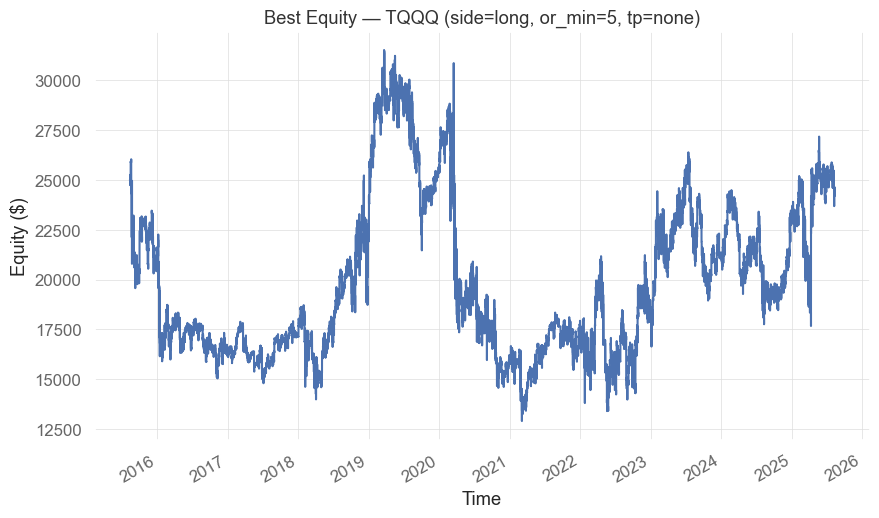

In [ ]:
# Plot best equity curve from Optuna best_params (if available)
if 'study' not in globals() or study is None or 'best' not in globals() or best is None:
    print("Optuna results unavailable (skipped or failed). Skipping Optuna best plot.")
else:
    best = study.best_params  # retrieve best params
    or_min = int(best['or_min'])  # OR minutes
    _tp_choice = best['tp']  # TP choice
    _stop_mode = 'tp_sl' if _tp_choice != 'none' else 'time_only'  # stop mode
    _tp_mult = None if _tp_choice == 'none' else float(_tp_choice)  # TP multiple

    # Rebuild on target period and auto-select side
    pdf_full = panels[TARGET_TICKER]
    pdf = _slice_period(pdf_full, TARGET_START, TARGET_END)
    pdf2, e_long, e_short, x = build_orb_signals(pdf, or_min)
    eq_l = simulate_vectorbt(pdf2, e_long, e_short, x, _tp_mult, SPREAD_BPS, SLIPPAGE_BPS, FEES_PER_SHARE, side='long', stop_mode=_stop_mode)
    eq_s = simulate_vectorbt(pdf2, e_long, e_short, x, _tp_mult, SPREAD_BPS, SLIPPAGE_BPS, FEES_PER_SHARE, side='short', stop_mode=_stop_mode)
    _side = _choose_side(eq_l, eq_s)
    _eq = eq_l if _side=='long' else eq_s
    _metrics, _dr = evaluate_equity(_eq)  # expose _metrics for guards

    # Readable recap
    print("Best Run Recap")
    print("-" * 66)
    print(f"Ticker            : {TARGET_TICKER}")
    print(f"Side              : {_side}")
    print(f"Opening Range     : {or_min} minutes")
    print(f"Take-profit (TP)  : {_tp_choice}")
    print(f"Exit mode         : {_stop_mode}")
    print(f"Return            : {_metrics['Return [%]']:.2f}%")
    print(f"Max Drawdown      : {_metrics['MaxDD [%]']:.2f}%")
    print(f"Sharpe (daily)    : {_metrics['Sharpe']:.2f}")

    import matplotlib.pyplot as plt
    plt.figure()
    _eq.plot(title=f"Best Equity — {TARGET_TICKER} (side={_side}, or_min={or_min}, tp={_tp_choice})")
    plt.xlabel("Time")
    plt.ylabel("Equity ($)")

Strategy vs Buy & Hold — Summary
Ticker            : TQQQ
Period            : 2015-08-13 → 2025-08-08
Initial Capital   : $25,000
- ORB Strategy
  Return          : -1.61% | Sharpe: 0.14 | MaxDD: -59.10%
- Buy & Hold
  Return          : 1812.03% | Sharpe: 0.65 | MaxDD: -82.38%
Conclusion
------------------------------------------------------------------
  Winner          : Buy & Hold
  Drawdown        : Buy & Hold has higher drawdown vs strategy
  Next steps      : If benchmark wins with comparable/lower risk, consider long-only, time-only exits, or different instruments/periods.


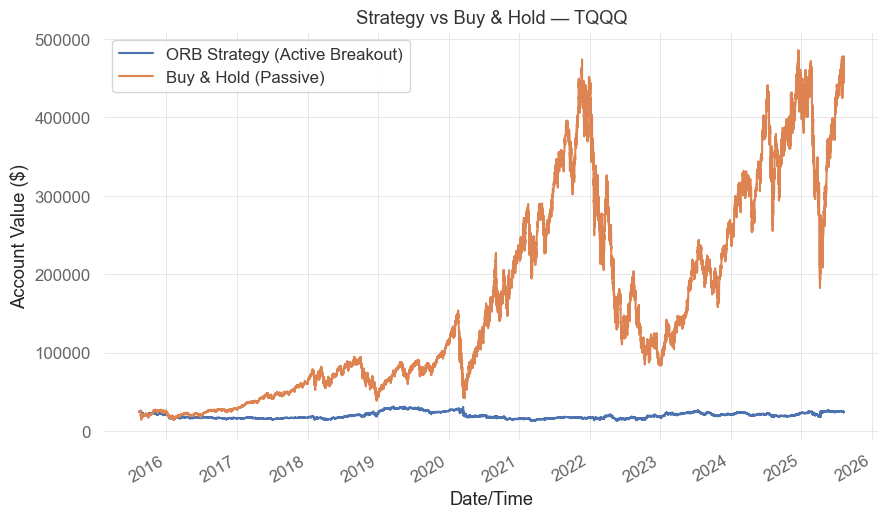

In [ ]:
# Buy-and-Hold benchmark vs. ORB best run — readable summary and conclusion
initial_cash = 25_000  # same as strategy

# Rebuild needed context safely
pdf_full = panels[TARGET_TICKER]
pdf = _slice_period(pdf_full, TARGET_START, TARGET_END)
if '_eq' not in globals():  # if best equity not present, rebuild using current best params
    # Fallback: use current config
    or_min_fb = OPEN_RANGE_MIN
    tp_choice_fb = 'none' if STOP_MODE_DEFAULT=='time_only' else TAKE_PROFIT_X
    stop_mode_fb = 'time_only' if tp_choice_fb == 'none' else 'tp_sl'
    tp_mult_fb = None if tp_choice_fb == 'none' else float(tp_choice_fb)
    pdf2_fb, e_long_fb, e_short_fb, x_fb = build_orb_signals(pdf, or_min_fb)
    eq_l_fb = simulate_vectorbt(pdf2_fb, e_long_fb, e_short_fb, x_fb, tp_mult_fb, SPREAD_BPS, SLIPPAGE_BPS, FEES_PER_SHARE, side='long', stop_mode=stop_mode_fb)
    eq_s_fb = simulate_vectorbt(pdf2_fb, e_long_fb, e_short_fb, x_fb, tp_mult_fb, SPREAD_BPS, SLIPPAGE_BPS, FEES_PER_SHARE, side='short', stop_mode=stop_mode_fb)
    _side = _choose_side(eq_l_fb, eq_s_fb)
    _eq = eq_l_fb if _side=='long' else eq_s_fb

# Build Buy & Hold equity (minute-level) aligned to Close prices
close = pdf['Close'].dropna()
if close.empty or '_eq' not in globals() or _eq.empty:
    print("Buy & Hold benchmark skipped: insufficient data/context for target period.")
else:
    shares = initial_cash / close.iloc[0]
    eq_bh = (shares * close).reindex(_eq.index).ffill().dropna()

    # Metrics
    m_strat, _ = evaluate_equity(_eq)
    m_bh, _ = evaluate_equity(eq_bh)

    # Pretty print summary
    line = "=" * 66
    print(line)
    print("Strategy vs Buy & Hold — Summary")
    print(line)
    print(f"Ticker            : {TARGET_TICKER}")
    print(f"Period            : {(_eq.index.min().date() if len(_eq)>0 else 'n/a')} → {(_eq.index.max().date() if len(_eq)>0 else 'n/a')}")
    print(f"Initial Capital   : ${initial_cash:,.0f}")
    print("- ORB Strategy")
    print(f"  Return          : {m_strat['Return [%]']:.2f}% | Sharpe: {m_strat['Sharpe']:.2f} | MaxDD: {m_strat['MaxDD [%]']:.2f}%")
    print("- Buy & Hold")
    print(f"  Return          : {m_bh['Return [%]']:.2f}% | Sharpe: {m_bh['Sharpe']:.2f} | MaxDD: {m_bh['MaxDD [%]']:.2f}%")

    # Conclusion
    better = 'Buy & Hold' if m_bh['Return [%]'] > m_strat['Return [%]'] else 'ORB Strategy'
    dd_note = 'lower' if abs(m_bh['MaxDD [%]']) < abs(m_strat['MaxDD [%]']) else 'higher'
    print(line)
    print("Conclusion")
    print("-" * 66)
    print(f"  Winner          : {better}")
    print(f"  Drawdown        : Buy & Hold has {dd_note} drawdown vs strategy")
    print("  Next steps      : If benchmark wins with comparable/lower risk, consider long-only, time-only exits, or different instruments/periods.")
    print(line)

    # Overlay chart
    import matplotlib.pyplot as plt
    plt.figure()
    _eq.plot(label='ORB Strategy (Active Breakout)')
    eq_bh.plot(label='Buy & Hold (Passive)')
    plt.title(f"Strategy vs Buy & Hold — {TARGET_TICKER}")
    plt.xlabel("Date/Time")
    plt.ylabel("Account Value ($)")
    plt.legend()

Generating full tear sheet (this may take a moment)...


Start date,2015-08-13
End date,2025-08-08
Total months,173
,Backtest
Annual return,-5.194%
Cumulative returns,-53.809%
Annual volatility,21.016%
Sharpe ratio,-0.15
Calmar ratio,-0.07
Stability,0.60
Max drawdown,-73.607%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,73.61,2015-12-06,2022-02-22,NaT,NaN
1,16.07,2015-08-19,2015-09-30,2015-12-04,78
2,1.07,2015-08-13,2015-08-14,2015-08-17,3
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


Top 10 long positions of all time,max


Top 10 short positions of all time,max


Top 10 positions of all time,max


TypeError: no numeric data to plot

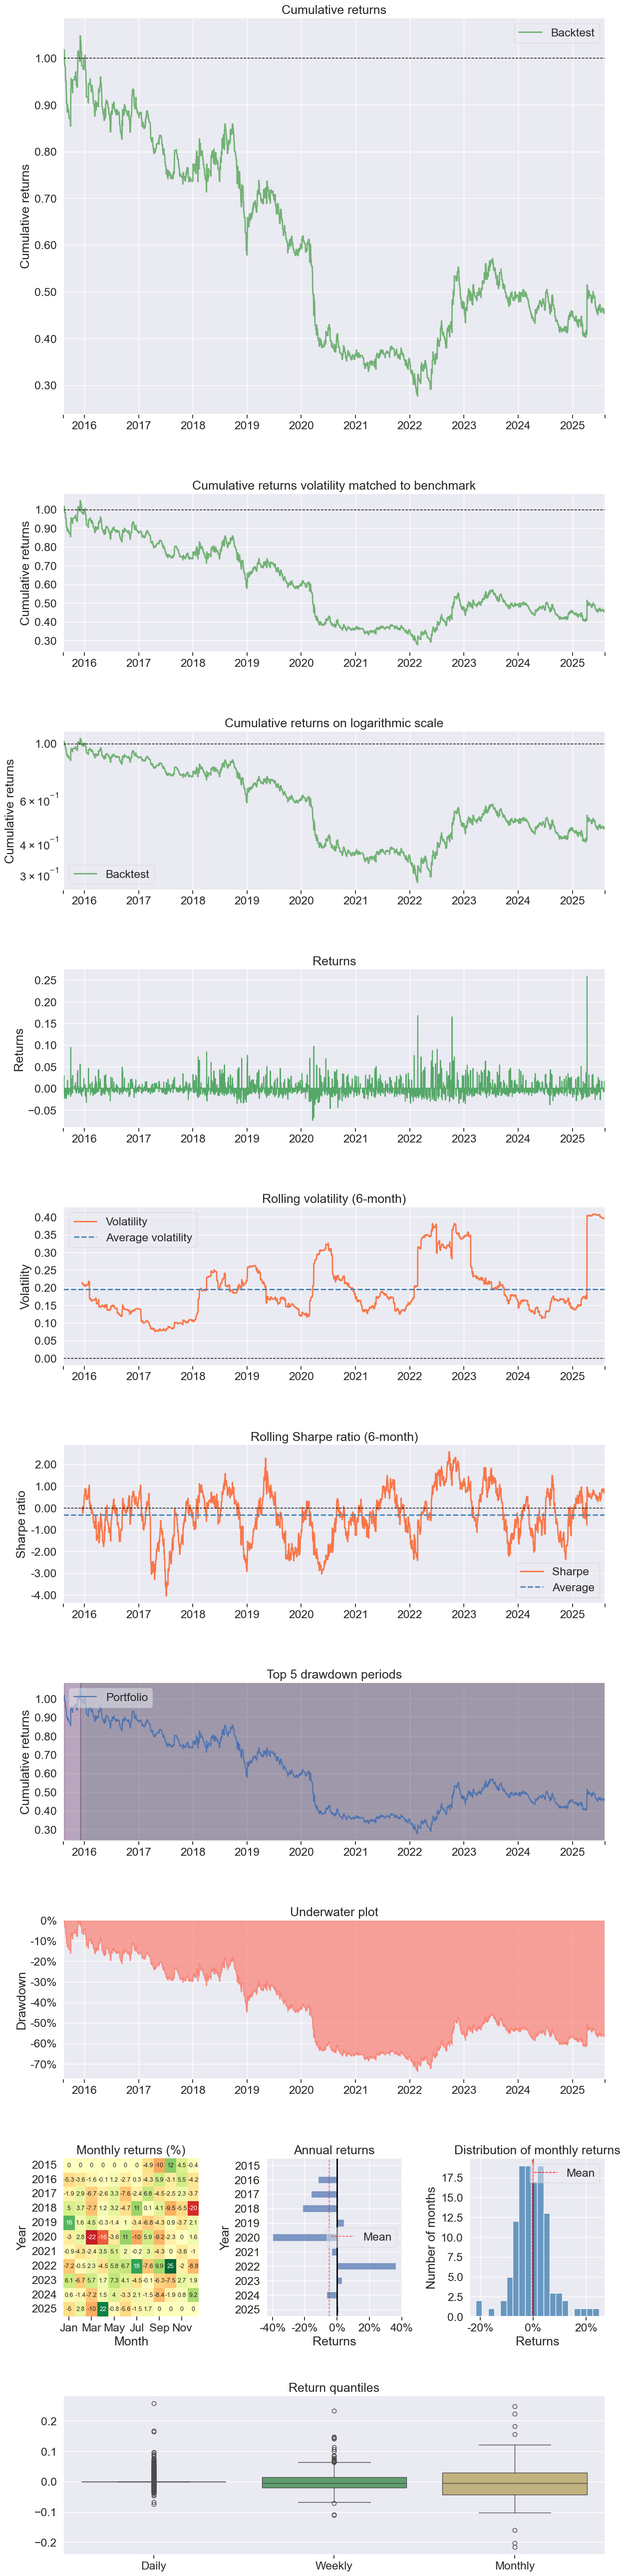

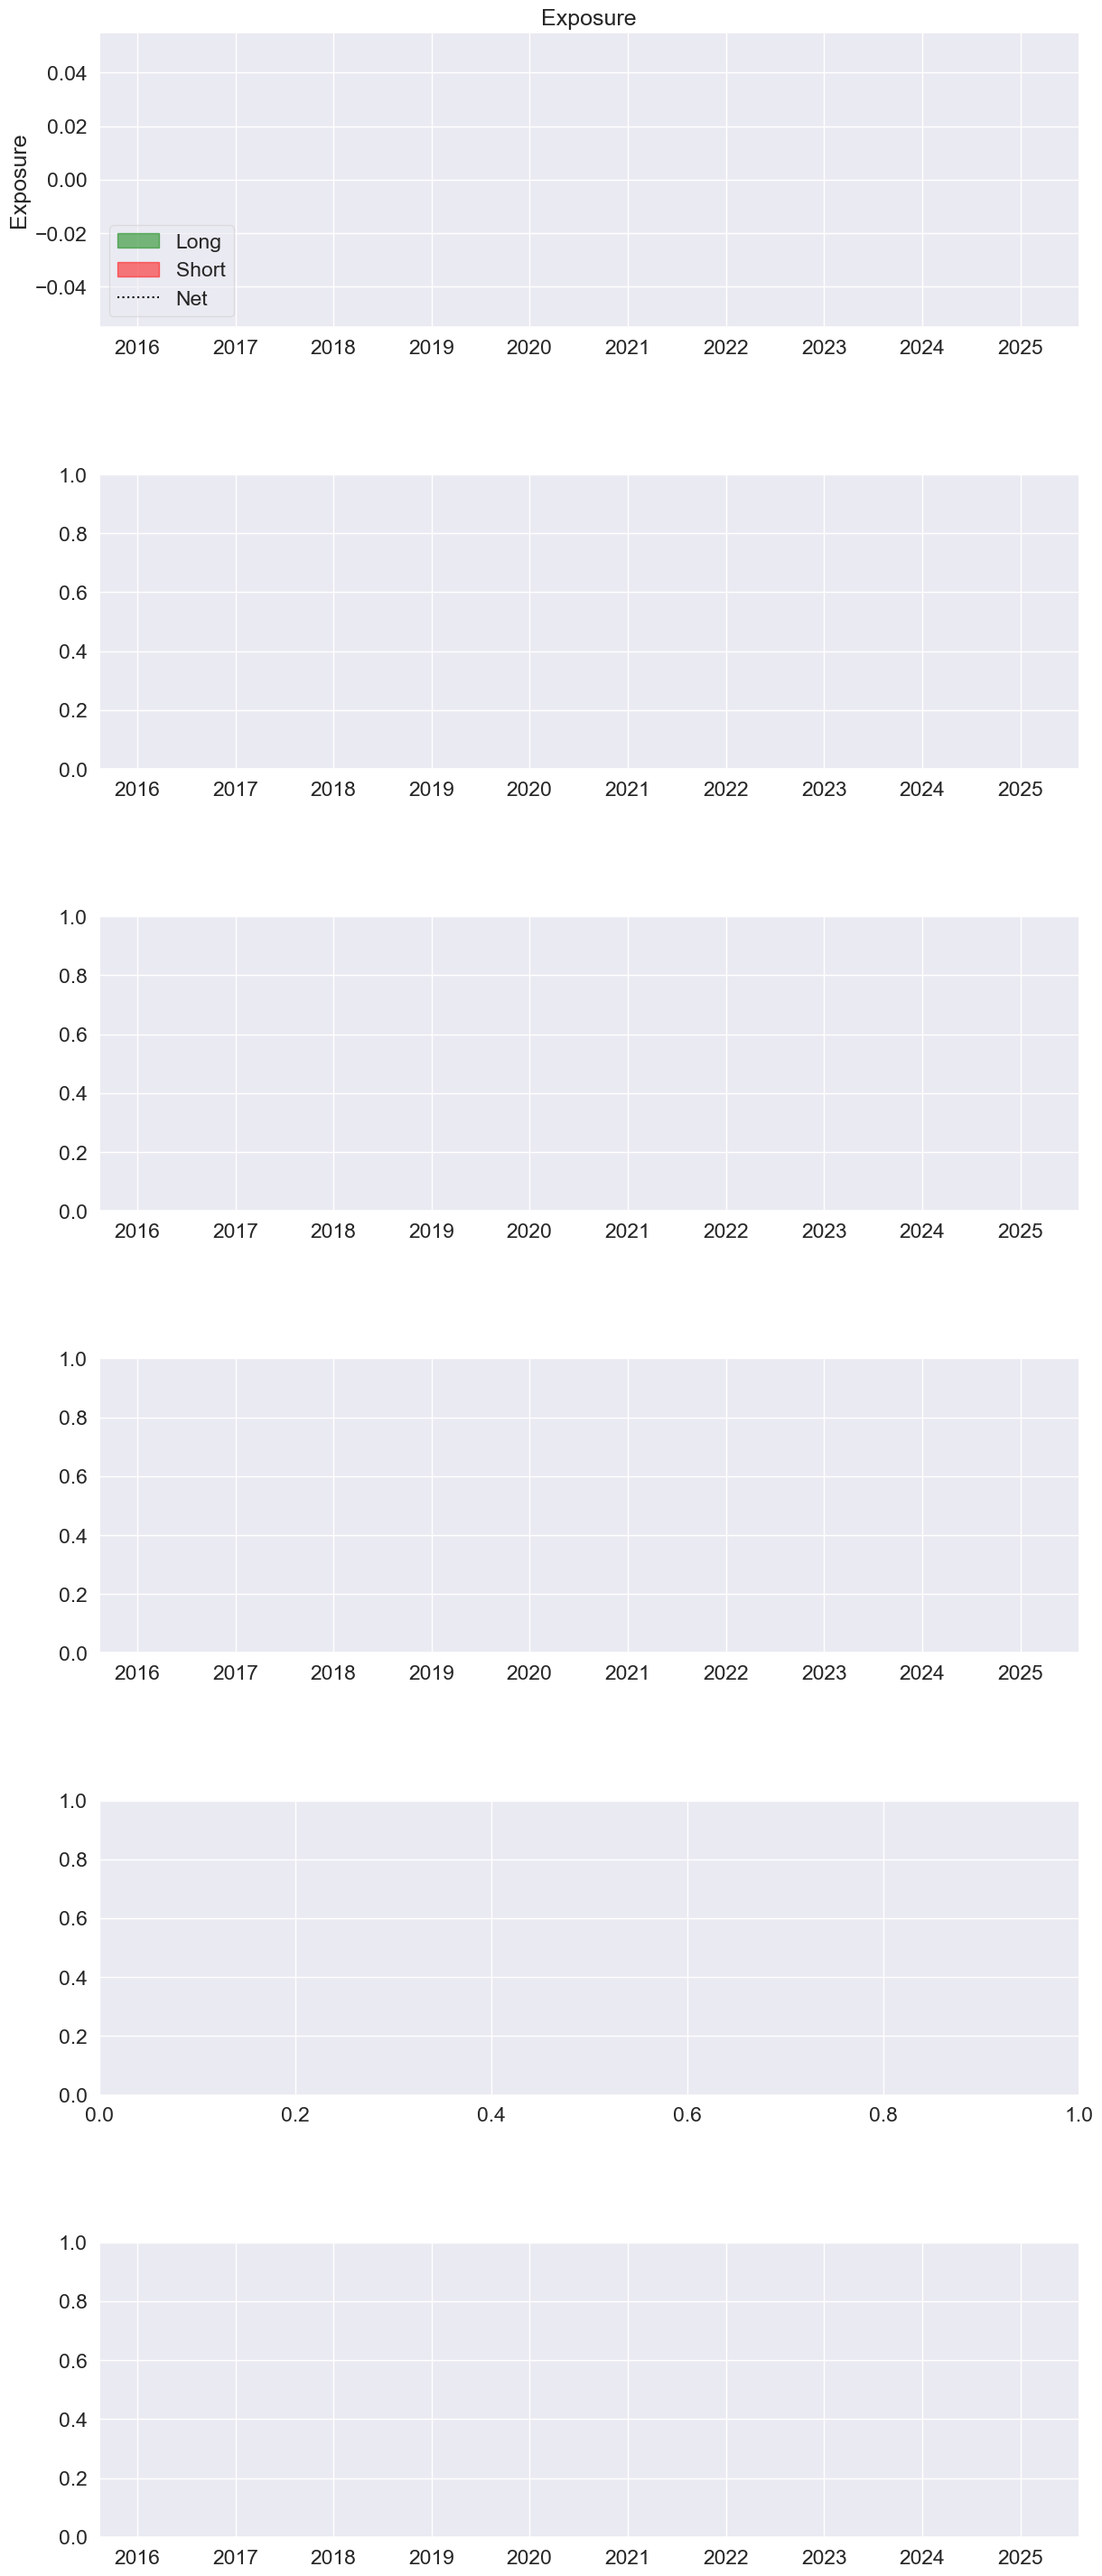

In [ ]:
# Build returns/positions/transactions if missing, then run pyfolio tear sheet safely

# 1) Returns: prefer daily_returns[TARGET_TICKER]; else derive from equity curve.
try:
    import pandas as pd
    import numpy as np
    if 'returns' not in globals() or not isinstance(returns, pd.Series):
        _ret = None
        if 'daily_returns' in globals() and isinstance(daily_returns, dict):
            _ret = daily_returns.get(TARGET_TICKER)
        if _ret is None and 'equity_curves' in globals() and TARGET_TICKER in equity_curves:
            _eq = equity_curves[TARGET_TICKER]
            if isinstance(_eq, pd.Series) and len(_eq) > 2:
                _ret = (
                    _eq.asfreq('min').ffill().pct_change().dropna()
                      .resample('1D').apply(lambda s: (1+s).prod()-1).dropna()
                )
        if _ret is None or not isinstance(_ret, pd.Series) or _ret.empty:
            raise RuntimeError("No returns available for tear sheet. Run Phase 1 cells earlier in the notebook.")
        returns = _ret
except Exception as _e:
    raise

# 2) Minimal positions/transactions fallbacks if missing
if 'positions' not in globals() or not isinstance(positions, pd.DataFrame) or positions.empty:
    positions = pd.DataFrame(index=returns.index)
    positions.insert(0, 'cash', 0.0)
if 'transactions' not in globals() or not isinstance(transactions, pd.DataFrame):
    transactions = pd.DataFrame(index=returns.index)

# 3) Ensure positions has a 'cash' column for pyfolio compatibility
if 'positions' in globals():
    try:
        import pandas as pd
        if isinstance(positions, pd.DataFrame) and 'cash' not in positions.columns:
            positions.insert(0, 'cash', 0.0)
    except Exception:
        pass

# 4) Normalize dtypes and indexes to avoid common warnings
try:
    import pandas as pd
    # Returns should be float64, sorted, and tz-naive
    if 'returns' in globals() and isinstance(returns, pd.Series):
        if returns.dtype != 'float64':
            returns = returns.astype('float64')
        returns = returns.sort_index()
        try:
            if getattr(returns.index, 'tz', None) is not None:
                returns = returns.tz_convert(None)
        except Exception:
            try:
                returns = returns.tz_localize(None)
            except Exception:
                pass
    # Positions: sort index and coerce all columns to numeric
    if 'positions' in globals() and isinstance(positions, pd.DataFrame):
        positions = positions.sort_index()
        positions = positions.apply(pd.to_numeric, errors='coerce')
    # Transactions: expected columns and dtypes
    if 'transactions' in globals() and isinstance(transactions, pd.DataFrame):
        # Coerce common columns to correct type if present
        for col in ['price', 'amount']:
            if col in transactions.columns:
                transactions[col] = pd.to_numeric(transactions[col], errors='coerce')
        if 'symbol' in transactions.columns:
            transactions['symbol'] = transactions['symbol'].astype(str)
        transactions = transactions.sort_index()
except Exception:
    pass

# 5) Decide whether to show positions panel based on holdings
pos_wo_cash = positions.drop(columns=['cash'], errors='ignore') if isinstance(positions, pd.DataFrame) else None
numeric_pos = pos_wo_cash.select_dtypes(include=[np.number]) if isinstance(pos_wo_cash, pd.DataFrame) else None
has_holdings = bool(numeric_pos is not None and numeric_pos.shape[1] > 0 and np.isfinite(numeric_pos.values).any() and (numeric_pos.fillna(0).abs().sum().sum() > 0))

# 6) Filter known noisy warnings from external libraries
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pyfolio')
warnings.filterwarnings('ignore', category=FutureWarning, module='pyfolio')
warnings.filterwarnings('ignore', message='.*Tight layout not applied.*', category=UserWarning, module='matplotlib')

print("Generating full tear sheet (this may take a moment)...")
# Disable intraday inference to avoid drop('cash') issues if not desired
_ts_kwargs = dict(
    returns=returns,
    positions=positions,
    transactions=transactions,
    round_trips=True,
    estimate_intraday=False,
)
if not has_holdings:
    _ts_kwargs['hide_positions'] = True
pf.create_full_tear_sheet(**_ts_kwargs)

## AI analysis and suggestions (LLM)

This section summarizes the current research outputs and uses an LLM to propose improvements: backtest realism, additional useful information, and concrete next steps to enhance the system.


In [ ]:
# Use an LLM to analyze results and suggest improvements before Phase 2
import os  # For reading environment variables
import json  # For JSON formatting of the prompt context
from datetime import datetime  # Timestamps for context

# Try to import OpenAI client; guard if not installed
try:
    from openai import OpenAI  # New SDK
    _HAS_OPENAI = True
except Exception:
    _HAS_OPENAI = False

# Configuration: model and API key source (defaults to 'gpt-5' as requested)
LLM_MODEL = os.environ.get('LLM_MODEL', 'gpt-5')
OPENAI_API_KEY = os.environ.get('OPENAI_API_KEY')  # Set this in your environment before running

# Build a compact context from what we have in-memory
ctx = {}
try:
    ctx['period'] = {'start': str(START), 'end': str(END)}
    ctx['target'] = {'ticker': TARGET_TICKER, 'universe_size': len(TICKERS) if isinstance(TICKERS, list) else None}
    if 'best_by_symbol' in globals() and hasattr(best_by_symbol, 'head'):
        ctx['best_by_symbol_head'] = best_by_symbol.head(5).to_dict(orient='index')
    if 'best' in globals() and isinstance(best, dict):
        ctx['best_run'] = best
    ctx['costs'] = {'spread_bps': SPREAD_BPS, 'slippage_bps': SLIPPAGE_BPS, 'fees_per_share': FEES_PER_SHARE}
    ctx['controls'] = {
        'active_side': ACTIVE_SIDE,
        'open_range_min': OPEN_RANGE_MIN,
        'optuna_or_choices': OPTUNA_OR_CHOICES,
        'optuna_tp_choices': OPTUNA_TP_CHOICES,
        'stop_mode_default': STOP_MODE_DEFAULT
    }
    if 'res_phase1_h' in globals():
        try:
            top = res_phase1_h.sort_values(['Sharpe Ratio','Total Return (%)'], ascending=[False, False]).head(1)
            ctx['winner_metrics'] = top.to_dict(orient='records')[0]
        except Exception:
            pass
    ctx['generated_at'] = datetime.utcnow().isoformat() + 'Z'
except Exception:
    pass

print("AI context prepared. Model:", LLM_MODEL)

prompt = f"""
You are a quantitative trading researcher. Given the context, propose:
1) 3-5 concrete improvements to the backtest realism and methodology.
2) 3-5 additional metrics, charts, or information a PM would find useful.
3) 3-5 practical ideas to improve the ORB strategy (entry/exit logic, filters, risk, regime).
Keep it concise, prioritized, and specific. Show brief rationales and risks.

Context (JSON):\n{json.dumps(ctx, indent=2)}
"""

if not _HAS_OPENAI:
    print("OpenAI SDK not installed. Skipping LLM call. Install 'openai' and set OPENAI_API_KEY.")
elif not OPENAI_API_KEY:
    print("OPENAI_API_KEY not set in environment; skipping LLM call. Set it and re-run this cell.")
else:
    try:
        client = OpenAI(api_key=OPENAI_API_KEY)
        resp = client.chat.completions.create(
            model=LLM_MODEL,
            messages=[
                {"role": "system", "content": "You are a seasoned quant PM and research lead."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3,
            max_tokens=800,
        )
        text = resp.choices[0].message.content
        print("\n===== AI suggestions =====\n")
        print(text)
    except Exception as e:
        print("LLM call failed:", repr(e))
        print("You can copy and paste this prompt into your LLM tool:")
        print(prompt)


AI context prepared. Model: gpt-5
LLM call failed: BadRequestError('Error code: 400 - {\'error\': {\'message\': "Unsupported parameter: \'max_tokens\' is not supported with this model. Use \'max_completion_tokens\' instead.", \'type\': \'invalid_request_error\', \'param\': \'max_tokens\', \'code\': \'unsupported_parameter\'}}')
You can copy and paste this prompt into your LLM tool:

You are a quantitative trading researcher. Given the context, propose:
1) 3-5 concrete improvements to the backtest realism and methodology.
2) 3-5 additional metrics, charts, or information a PM would find useful.
3) 3-5 practical ideas to improve the ORB strategy (entry/exit logic, filters, risk, regime).
Keep it concise, prioritized, and specific. Show brief rationales and risks.

Context (JSON):
{
  "period": {
    "start": "2015-08-16",
    "end": "2025-08-13"
  },
  "target": {
    "ticker": "TQQQ",
    "universe_size": 4
  },
  "best_by_symbol_head": {
    "0": {
      "Ticker": "TQQQ",
      "or_min


## PHASE 2 — Zipline-Reloaded Mirror — **COMMENTED**
Uncomment when ready to validate in an event-driven engine.


In [ ]:
# (Optional) Zipline setup — create a minimal local csvdir bundle from current minute data
# This lets Phase 2 run without relying on deprecated external bundles.
_run_phase2 = False  # default guard
try:
    # If Optuna ran and _metrics exists, use it; else if res_phase1 exists, use the top ticker metric
    if '_metrics' in globals() and isinstance(_metrics, dict):
        _run_phase2 = (_metrics.get('Return [%]', -1) > 0)
    elif 'res_phase1' in globals() and not pd.isna(res_phase1.iloc[0]['Return [%]']):
        _run_phase2 = (res_phase1.iloc[0]['Return [%]'] > 0)
except Exception:
    _run_phase2 = False

if not _run_phase2:
    print("Phase 2 setup skipped (equity curve not positive or unavailable).")
else:
    try:  # try importing zipline
        import zipline  # check if zipline-reloaded is installed
        from zipline.data.bundles import register, ingest  # bundle APIs
        from zipline.data.bundles.csvdir import csvdir_equities  # csvdir helper
        _zipline_ok = True  # mark available
    except Exception as _e:  # if import fails
        _zipline_ok = False  # mark unavailable
        print("zipline-reloaded not available in this kernel. Install with: pip install zipline-reloaded alembic")  # guidance

    if _zipline_ok:  # proceed only if zipline present
        import os, shutil  # os utilities
        # Pick a symbol we already loaded (prefer SPY)
        _sym = 'SPY' if 'SPY' in panels else (next(iter(panels)) if panels else None)  # choose symbol
        if not _sym:  # no data to export
            print("No data panels available to build a csvdir bundle. Run Phase 1 data loader first.")  # notify
        else:  # have a symbol
            # Prepare csvdir structure: <CSVDIR>/minute/<SYMBOL>.csv
            _csv_root = os.path.join(BASE_DIR, 'zipline_csvdir')  # root folder
            _minute_dir = os.path.join(_csv_root, 'minute')  # minute subfolder
            os.makedirs(_minute_dir, exist_ok=True)  # ensure directories
            # Write CSV for the chosen symbol (UTC index required by zipline, ISO format)
            _pdf = panels[_sym].copy()  # copy panel
            _pdf.index = pd.to_datetime(_pdf.index, utc=True)  # ensure UTC tz
            _out = _pdf.rename(columns={  # rename to zipline schema
                'Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'
            })[['open','high','low','close','volume']]  # select columns
            _csv_path = os.path.join(_minute_dir, f'{_sym}.csv')  # output path
            _out.to_csv(_csv_path, index_label='date')  # write CSV
            print(f'Wrote minute CSV for {_sym} to: {_csv_path}')  # report path

            # csvdir_equities expects CSVDIR env var pointing to the root folder
            os.environ['CSVDIR'] = _csv_root  # set environment variable
            print('Set CSVDIR =', os.environ['CSVDIR'])  # confirm

            # Register a local csvdir bundle pointing at our folder
            _bundle_name = 'orb_csvdir_min'  # bundle name
            try:  # attempt registration and ingestion
                register(
                    _bundle_name,  # name
                    csvdir_equities(symbols=[_sym]),  # csvdir ingest factory
                    calendar_name='XNYS'  # NYSE calendar
                )  # register bundle
                # Ingest the bundle into the default ZIPLINE_ROOT
                ingest(_bundle_name, show_progress=False)  # ingest data
                print(f'Registered and ingested bundle: {_bundle_name}')  # success message
                print('Phase 2 will attempt to use this bundle if specified.')  # hint
            except Exception as _e:  # on failure
                print('Failed to register/ingest csvdir bundle:', _e)  # log error
                print('Verify the csv structure is <CSVDIR>/minute/<SYMBOL>.csv and try again.')  # guidance

In [ ]:
from zipline.api import order_target, record, symbol, set_commission, set_slippage  # trading APIs
from zipline import run_algorithm  # backtest runner
from zipline.finance import commission, slippage  # execution models
import pytz  # timezone utilities

if not globals().get('_run_phase2', False):  # guard
    print("Phase 2 run skipped (equity curve not positive or setup not run).")
else:
    def initialize(context):  # called once at start
        context.asset = symbol('SPY')  # set target asset
        set_commission(commission.PerShare(cost=0.0005))  # per-share commission
        set_slippage(slippage.VolumeShareSlippage(volume_limit=0.1, price_impact=0.1))  # simple slippage model

    def handle_data(context, data):  # called each bar
        current = data.current(context.asset, 'price')  # get current price
        record(price=current)  # record for analysis

    # Default to global START/END
    start = pd.Timestamp(START.isoformat(), tz='utc')  # start date in UTC
    end   = pd.Timestamp(END.isoformat(), tz='utc')  # end date in UTC

    # If we have SPY panel data, tighten to its available range to match our csvdir bundle
    if 'SPY' in panels and not panels['SPY'].empty:  # ensure panel exists
        _spy = panels['SPY']  # get SPY panel
        start = pd.Timestamp(_spy.index[0], tz='utc')  # align start
        end   = pd.Timestamp(_spy.index[-1], tz='utc')  # align end

    # Prefer our local csvdir bundle if it was registered/ingested
    _bundle = 'orb_csvdir_min'  # our bundle name
    try:  # attempt to run
        result = run_algorithm(  # run backtest
            start=start,  # start date
            end=end,  # end date
            initialize=initialize,  # init function
            capital_base=25000,  # initial equity
            handle_data=handle_data,  # bar handler
            data_frequency='minute',  # minute data
            bundle=_bundle  # data bundle
        )  # returns a DataFrame
        display(result.tail())  # show last few rows
    except Exception as e:  # on failure
        print("Zipline run failed. Likely missing data bundle.")  # error message
        print("Error:", e)  # show exception
        print("Tip: Run the 'Zipline setup' cell above to register and ingest a local csvdir bundle, or install zipline-reloaded and try again.")  # guidance


## PHASE 3 — Robustness (PurgedKFold, Walk-Forward) — **COMMENTED**


In [ ]:
# Only run Phase 3 if equity curve is positive
_run_phase3 = False
try:
    if ' _metrics' in globals() and isinstance(_metrics, dict):
        _run_phase3 = (_metrics.get('Return [%]', -1) > 0)
    elif 'res_phase1' in globals() and not pd.isna(res_phase1.iloc[0]['Return [%]']):
        _run_phase3 = (res_phase1.iloc[0]['Return [%]'] > 0)
except Exception:
    _run_phase3 = False

if not _run_phase3:
    print("Phase 3 skipped (equity curve not positive or unavailable).")
else:
    try:  # attempt to import mlfinlab
        from mlfinlab.cross_validation import PurgedKFold  # CV tool
    except Exception:  # if not installed
        print("mlfinlab not available. Install with: pip install mlfinlab")  # guidance
    else:  # proceed when available
        TARGET_TICKER = TARGET_TICKER  # use configured target
        pdf = panels[TARGET_TICKER]  # get panel
        pdf = _slice_period(pdf, TARGET_START, TARGET_END)  # slice period
        pdf2, e_long, e_short, x = build_orb_signals(pdf, OPEN_RANGE_MIN)  # build signals
        X = pd.DataFrame(index=pdf2.index)  # dummy features as placeholder
        y = e_long.astype(int)  # label: long entry as 1/0
        pkf = PurgedKFold(n_splits=5, embargo_td=pd.Timedelta(minutes=30))  # time-aware CV splitter
        for i, (train_idx, test_idx) in enumerate(pkf.split(X, y, times=pd.Series(pdf2.index, index=pdf2.index))):  # iterate folds
            print(f"Fold {i}: train={len(train_idx)}, test={len(test_idx)}")  # report fold sizes